# 02 Text cleanup and data exploration

In this notebook we will explore the books we downloaded and try to clean them up. We will try to answer the following questions:
<ul>
    <li>how can we <b>eliminate</b> parts of the text that are not written by the author but by some of the participants of the publishing process (e.g introductions, legal disclaimers)?</li>
    <li> are there any <b>duplications</b>? </li>
    <li> how can we avoid that the <b>classifier uses style elements and not other elements</b> to classify a text?</li>
    <li>are there any boooks that <b>belong together</b>?</li>
    
    
</ul>

Let's import our catalog dataframe and clean up with the multiple-line titles in it.

In [1]:
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #we supress the tensorflow info messages
sel_gut_df=pd.read_csv('sel_gut_df.csv', index_col=0)
sel_gut_df['title']=sel_gut_df['title'].replace({r'\r': '', r'\n': ' '}, regex=True)

Let's import a text and have a look at it:

In [2]:
def readbook(dfindex):
    
    book=sel_gut_df.loc[dfindex]
    filename=os.path.join("rawtext", book["author"], str(dfindex))
    with open(filename, 'r') as f:
        booktext=f.read()
    return booktext
text=readbook(67940)
print(text[:2000])

﻿The Project Gutenberg eBook of Œuvres complètes de Guy de
Maupassant - volume 19, by Guy de Maupassant

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Œuvres complètes de Guy de Maupassant - volume 19

Author: Guy de Maupassant

Release Date: April 27, 2022 [eBook #67940]

Language: French

Produced by: Claudine Corbasson and the Online Distributed Proofreading
             Team at https://www.pgdp.net (This file was produced from
             images generously made available by The Internet
             Archive/Canadian Libraries)

*** START OF THE PROJECT GUTENBERG EBOOK ŒUVRES COMPLÈTE

This first part of the text cannot really be used. I was not written by Maupassant but different participants of the publishing process and of the Gutenberg Project. We can strip it with the strip_headers function from gutenbergpy.

In [3]:
from gutenbergpy.textget import strip_headers as strip_headers_bytes
def strip_headers(text):
    return strip_headers_bytes(text.encode()).decode('utf-8')

In [4]:
print(strip_headers(text)[:1000])

MAUPASSANT - VOLUME 19 ***





  Au lecteur

  Cette version numérisée reproduit dans son intégralité la version
  originale. Toutefois, une erreur typographique a été corrigée.
  On trouvera l'errata à la fin du volume.

  La ponctuation a pu faire l'objet de quelques corrections mineures.




  ŒUVRES COMPLÈTES

  DE

  GUY DE MAUPASSANT




  LA PRÉSENTE ÉDITION
  DES
  ŒUVRES COMPLÈTES DE GUY DE MAUPASSANT
  A ÉTÉ TIRÉE
  PAR L'IMPRIMERIE NATIONALE
  EN VERTU D'UNE AUTORISATION
  DE M. LE GARDE DES SCEAUX
  EN DATE DU 30 JANVIER 1902.


  IL A ÉTÉ TIRÉ DE CETTE ÉDITION
  100 EXEMPLAIRES SUR PAPIER DE LUXE
  SAVOIR:

  60 exemplaires (1 à 60) sur japon ancien.
  20 exemplaires (61 à 80) sur japon impérial.
  20 exemplaires (81 à 100) sur chine.


  _Le texte de ce volume
  est conforme à celui de l'édition originale_: Pierre et Jean
  _Paris, Paul Ollendorff, éditeur, 1888._




  ŒUVRES COMPLÈTES

  DE

  GUY DE MAUPASSANT


  PIERRE ET JEAN

  [Illustration]


  PARIS
  LOUIS CON

This function strips most but not all of the metadata and legal boilerplate by project gutenberg itself. Furthermore, it doesn't help us stripping the colophon and other initiatory text not written by the author.
Fortunately, for our purposes, we do not need the whole text. We just need enough samples from all authors. If we skip some text from the beginning, we will still have enough text to train our classifier.
So let's try determine the length of the books to decide how much we can strip.
In the same step, we will also try to determine the year of the book. This often but not always figures at the beginnning of the book, after the boilerplate and it should be between 1800 and 1929 (When Anatole France, the last of them to die, died in 1924).

In [5]:
import re
for i, row in sel_gut_df.iterrows():
    book=strip_headers(readbook(i))
    sel_gut_df.loc[i, 'length']=int(len(book))
    year_candidate=re.search( r"(18\d\d|19[012]\d)", readbook(i)[:2000])
    if type(year_candidate)!=type(None):
        sel_gut_df.loc[i, 'year']=int(year_candidate[0])

In [6]:
print('Ordered by length (in character)')
display(sel_gut_df.sort_values('length'))
print('Ordered by inferred year of publication')
display(sel_gut_df.sort_values('year'))

Ordered by length (in character)


title           author  \
number                                                                     
12448                                            L'Orco      George Sand   
63794   La comédie de celui qui épousa une femme muette   Anatole France   
12837                                              Cora      George Sand   
28623                        Le poëme de Myrza - Hamlet      George Sand   
12862                                    Aldo le rimeur      George Sand   
...                                                 ...              ...   
14287                                 L'île mystérieuse      Jules Verne   
37771                                 Le comte de Moret  Alexandre Dumas   
13951                           Les trois mousquetaires  Alexandre Dumas   
34528                                              Rome       Émile Zola   
13952                                   Vingt ans après  Alexandre Dumas   

           length    year  
number                     
12448     37504.0     NaN  
63794     48980.0  1912.0  
12837     60900.0     NaN  
28623     62973.0     NaN  
12862     66878.0     NaN  
...           ...     ...  
14287   1209054.0  1875.0  
37771   1213357.0  1866.0  
13951   1344887.0     NaN  
34528   1435790.0  1896.0  
13952   1658962.0  1845.0  

[341 rows x 4 columns]

Ordered by inferred year of publication


title             author  \
number                                                                         
18003                      La femme au collier de velours    Alexandre Dumas   
18006                        Le Chevalier de Maison-Rouge    Alexandre Dumas   
17693                              La San-Felice, Tome 01    Alexandre Dumas   
18028                            Le chevalier d'Harmental    Alexandre Dumas   
6838                        Le Dernier Jour d'un Condamné        Victor Hugo   
...                                                   ...                ...   
56054           Les trois mousquetaires, Volume  1 (of 2)    Alexandre Dumas   
13668                             Le château des Désertes        George Sand   
7772                           Les Quarante-Cinq — Tome 3    Alexandre Dumas   
38674   De la terre à la lune, trajet direct en 97 heu...        Jules Verne   
11597                  Mademoiselle Fifi: nouveaux contes  Guy de Maupassant   

          length    year  
number                    
18003   331358.0  1800.0  
18006   797859.0  1800.0  
17693   388396.0  1800.0  
18028   992101.0  1802.0  
6838    198880.0  1802.0  
...          ...     ...  
56054   718842.0     NaN  
13668   294819.0     NaN  
7772    459954.0     NaN  
38674   344732.0     NaN  
11597   210212.0     NaN  

[341 rows x 4 columns]

Let's visualize the distribution of length and the distribution of inferred publication year.

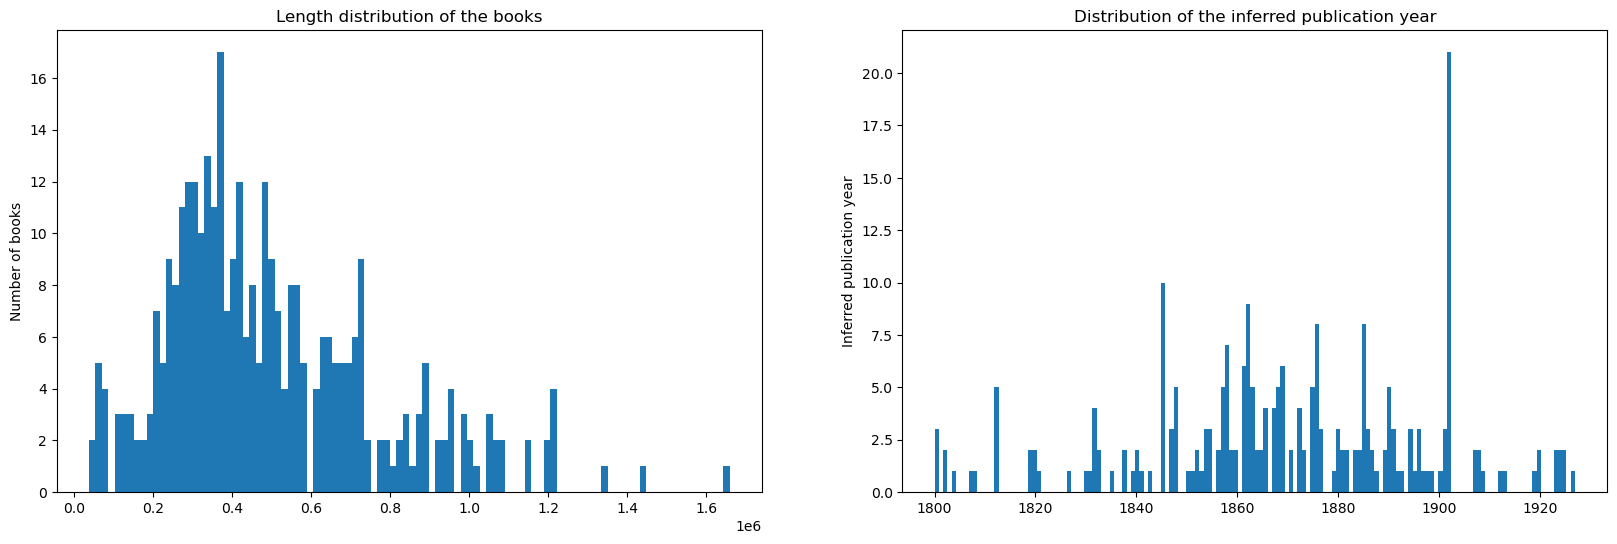

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 2,  figsize=(20, 6))
axs[0].hist(sel_gut_df['length'], bins=100)
axs[0].set_title('Length distribution of the books')
axs[0].set_ylabel('Number of books')
axs[0].set_ylabel('Book length in characters')
axs[1].hist(sel_gut_df['year'], bins=150)
axs[1].set_title('Distribution of the inferred publication year')
axs[0].set_ylabel('Number of books')
axs[1].set_ylabel('Inferred publication year')
plt.show()

Let's look at some of the years which occur often.

In [8]:
most_common_years=sel_gut_df['year'].value_counts()
print('Most common inferred publication years:')
display(most_common_years.head(10))
print('\n\nBooks with the 3 common inferred publication years:')
sel_gut_df[sel_gut_df['year'].isin(most_common_years.head(3).index)]
    

Most common inferred publication years:


1902.0    21
1845.0    10
1862.0     9
1876.0     8
1885.0     8
1858.0     7
1869.0     6
1861.0     6
1812.0     5
1848.0     5
Name: year, dtype: int64



Books with the 3 common inferred publication years:


title  \
number                                                      
12367                Le péché de Monsieur Antoine, Tome 1   
51266   Œuvres complètes de Guy de Maupassant - volume 06   
50144   Œuvres complètes de Guy de Maupassant - volume 05   
4548                              Cinq Semaines En Ballon   
17489                      Les misérables Tome I: Fantine   
41251           Cours familier de Littérature - Volume 14   
45119   Œuvres complètes de Guy de Maupassant - volume 01   
53247   Œuvres complètes de Guy de Maupassant - volume 09   
17992                   Le comte de Monte-Cristo, Tome IV   
67074   Œuvres complètes de Guy de Maupassant - volume 17   
45312   Œuvres complètes de Guy de Maupassant - volume 02   
13744                                             Isidora   
45753                                             Tamaris   
56523   Œuvres complètes de Guy de Maupassant - volume 12   
55167   Œuvres complètes de Guy de Maupassant - volume 10   
60610   Œuvres complètes de Guy de Maupassant - volume 15   
15287                                            Teverino   
68271   Œuvres complètes de Guy de Maupassant - volume 21   
56374   Œuvres complètes de Guy de Maupassant - volume 11   
46387   Œuvres complètes de Guy de Maupassant - volume 03   
17989                    Le comte de Monte-Cristo, Tome I   
51423   Œuvres complètes de Guy de Maupassant - volume 07   
17494                     Les misérables Tome III: Marius   
17493                     Les misérables Tome II: Cosette   
40195           Cours familier de Littérature - Volume 13   
46470   Œuvres complètes de Guy de Maupassant - volume 04   
67158   Œuvres complètes de Guy de Maupassant - volume 18   
57567   Œuvres complètes de Guy de Maupassant - volume 14   
17990                   Le comte de Monte-Cristo, Tome II   
68036   Œuvres complètes de Guy de Maupassant - volume 20   
13952                                     Vingt ans après   
52753   Œuvres complètes de Guy de Maupassant - volume 08   
67024   Œuvres complètes de Guy de Maupassant - volume 16   
17991                  Le comte de Monte-Cristo, Tome III   
17518   Les misérables Tome IV: L'idylle rue Plumet et...   
57430   Œuvres complètes de Guy de Maupassant - volume 13   
17519                 Les misérables Tome V: Jean Valjean   
13857                           La reine Margot - Tome II   
67940   Œuvres complètes de Guy de Maupassant - volume 19   
13856                            La reine Margot - Tome I   

                       author     length    year  
number                                            
12367             George Sand   559615.0  1845.0  
51266       Guy de Maupassant   228080.0  1902.0  
50144       Guy de Maupassant   449602.0  1902.0  
4548              Jules Verne   489791.0  1862.0  
17489             Victor Hugo   658260.0  1862.0  
41251   Alphonse de Lamartine   404907.0  1862.0  
45119       Guy de Maupassant   338140.0  1902.0  
53247       Guy de Maupassant   253705.0  1902.0  
17992         Alexandre Dumas   716024.0  1845.0  
67074       Guy de Maupassant   494956.0  1902.0  
45312       Guy de Maupassant   133946.0  1902.0  
13744             George Sand   339012.0  1845.0  
45753             George Sand   410989.0  1862.0  
56523       Guy de Maupassant   262057.0  1902.0  
55167       Guy de Maupassant   329121.0  1902.0  
60610       Guy de Maupassant   276242.0  1902.0  
15287             George Sand   312463.0  1845.0  
68271       Guy de Maupassant   200051.0  1902.0  
56374       Guy de Maupassant   243595.0  1902.0  
46387       Guy de Maupassant   302813.0  1902.0  
17989         Alexandre Dumas   727501.0  1845.0  
51423       Guy de Maupassant   239851.0  1902.0  
17494             Victor Hugo   512165.0  1862.0  
17493             Victor Hugo   581624.0  1862.0  
40195   Alphonse de Lamartine   374471.0  1862.0  
46470       Guy de Maupassant   242742.0  1902.0  
67158       Guy de Maupassant   292163.0  1902.0  
57567     

As this is clear from the top of the dataframe sorted by year (see further above), the inferred publication date is very often missing or is not the real one. (The first volume of La San-Felice talks about 1800 in its second sentence, but was published in 1864.) While the publication year would be a highly interesting metadata, it is hard to extract just by using regex. The most common value is 1902, when the Gutenberg version of Maupassant's complete works were published.

As for the length, the lessons are not evident either. The documents contain novels, novel volumes, volumes of collected works, short stories etc. 

Let's strip 3000 characters both from the beginning and the end of the texts, plus 10 % from the beginning and 20% from the end. A big part of the text will still remain, as it is clear from the above lengths.

To test whether we now have only the text of the author, let's choose 20 books randomly and print the first and last 100 characters of the stripped texts.

In [9]:
import random
random.seed(0)
# this function is for stripping the beginning and the end of the book, for eliminating 
# the new line characters within a paragraph and the leading and trailing spaces of the lines
def strip_book(i):
    no_headers=strip_headers(readbook(i))
    strip_begin=3000+int(.1*sel_gut_df.loc[i,'length'])
    strip_end=3000+int(.2*sel_gut_df.loc[i, 'length'])
    stripped=no_headers[strip_begin:-strip_end]
    paras_raw=stripped.split('\n\n')[1:-1]
    paras_final=[]
    for para in paras_raw:
        paras_final.append(" ".join([line.lstrip().rstrip() for line in para.split('\n')]))
    return paras_final
# this function is for eliminating the new lines within the paragraphs and 
# changing the double new lines to single ones between paragraphs
def finalstrip(i):
    return '\n'.join(strip_book(i))
for i in random.sample(list(sel_gut_df.index), 20):
    print('\n\n', sel_gut_df.loc[i, 'author']+":", sel_gut_df.loc[i, 'title'], '\n')
    print(finalstrip(i)[:100])
    print(finalstrip(i)[-100:])



 Alphonse de Lamartine: Cours familier de Littérature - Volume 26 

MACBETH.
Vous connaissez chacun votre rang, prenez vos places. Depuis le premier jusqu'au dernier, j
ement par sa valeur pendant la guerre, mais dans la paix, par sa magnanimité, les plus grands rois.»


 Guy de Maupassant: Fort comme la mort 

Quand elle se sentit tout à coup enlacée par lui et baisée passionnément sur les lèvres, elle voulut
l'ivresse unique de la gloire, lui avaient fait savourer des heures inoubliables de triomphe intime.


 Anatole France: La vie littéraire. Troisième série 

Ce sacristain est de l'école de M. Paul Stapfer, qui ne veut point qu'on embellisse Rabelais par de 
'ils sont très jeunes, qu'ils ont bu du lait et que la forêt s'éveille dans l'aube et dans la rosée.


 Gustave Flaubert: OEuvres complètes de Gustave Flaubert, tome 6: Trois contes, suivis de mélanges inédits 

Une grande armoire gênait pour ouvrir la porte. En face de la fenêtre surplombant le jardin, un œil-
in l'ascensio

## Duplication checking

Let's see if we have duplicates among the texts. We only have to cross-check the texts written by the same author. First we look at similarity between texts using tf-idf. To avoid very common words, we use spacy's stop words list and the 3000 most common cords from a word frequency package. 

We first generate the tf-idf matrix.

In [10]:
text_list=[finalstrip(i) for i in sel_gut_df.index]


from sklearn.feature_extraction.text import TfidfVectorizer
from wordfreq import top_n_list
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop1
fr_stop2=top_n_list('fr', 3000)
fr_stop=list(set(fr_stop1)&set(fr_stop1))+['neuf', 'qu', 'quelqu']
tfidf = TfidfVectorizer(stop_words=list(fr_stop))
tfidf_mtx = tfidf.fit_transform(text_list)

We then calculate the cosine similarity between the books of the same author.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
sim_mtx={}
tfidf_mtx_a={}
for author, group in sel_gut_df.groupby('author'):
    tfidf_mtx_a[author]=tfidf_mtx[[sel_gut_df.index.get_loc(i) for i in group.index]]
    sim_mtx[author]=cosine_similarity(tfidf_mtx_a[author], tfidf_mtx_a[author])

Alexandre Dumas


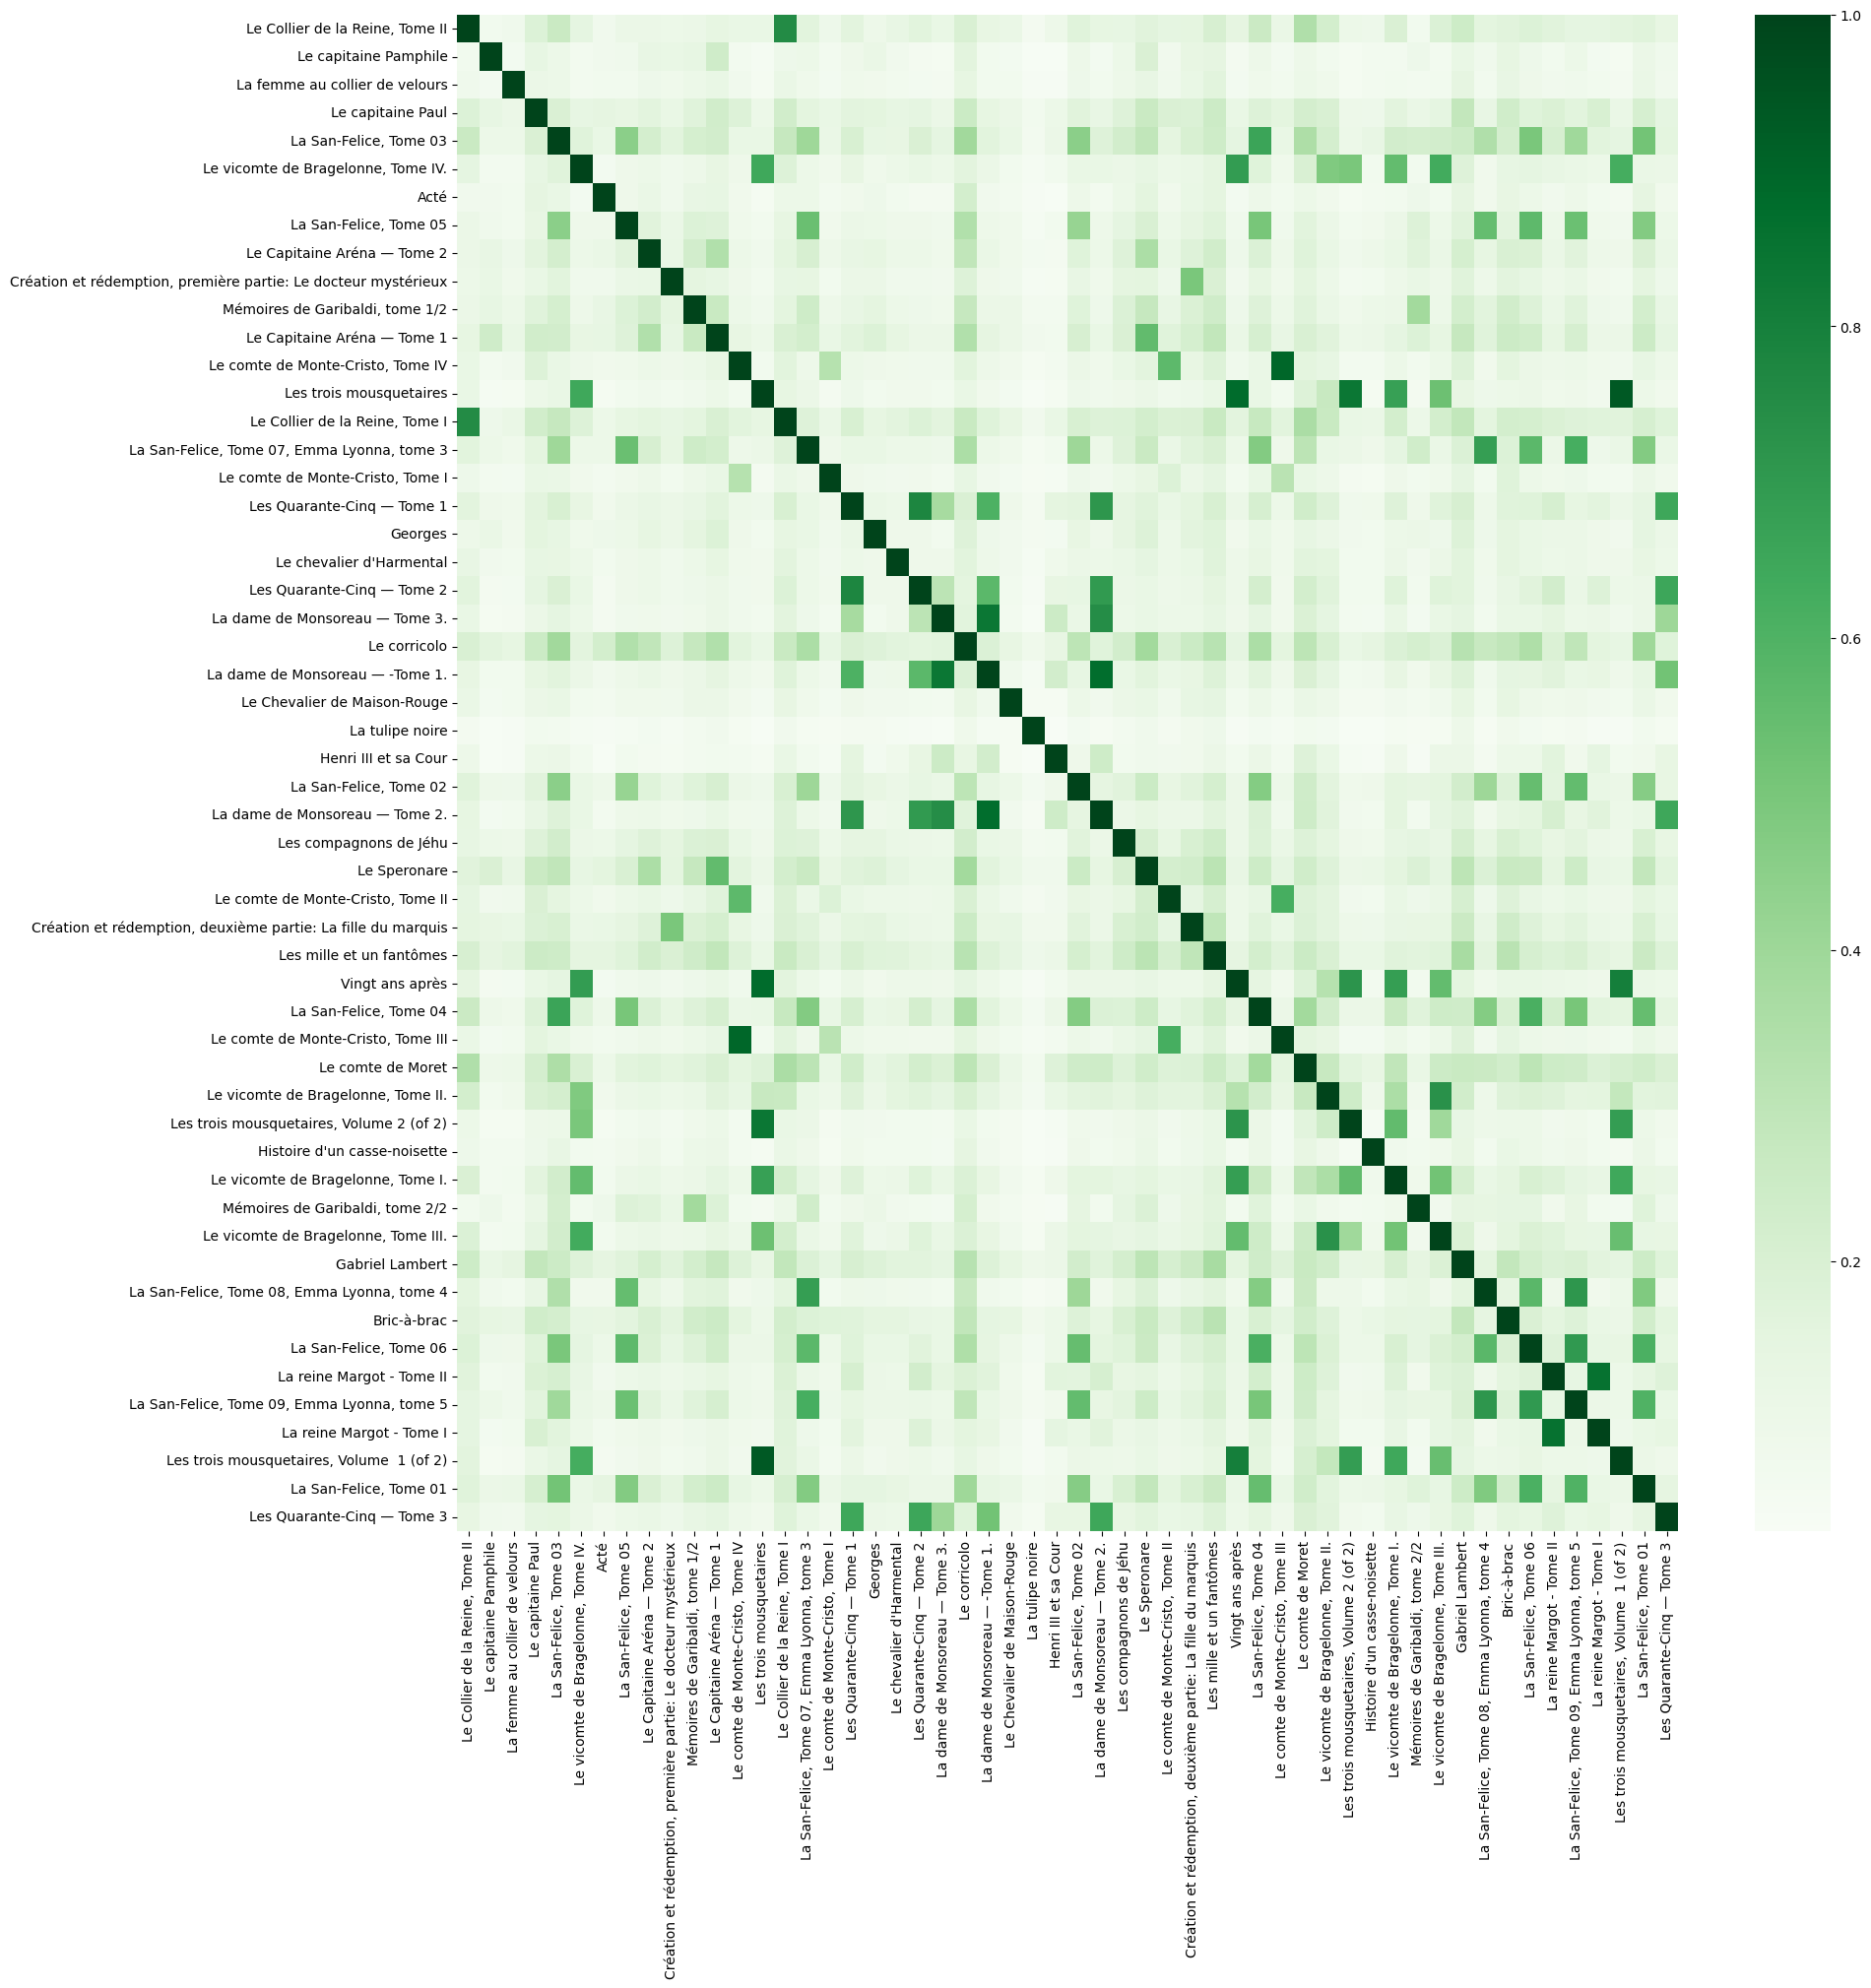

Possible duplicates:

Le Collier de la Reine, Tome I (18199) and
Le Collier de la Reine, Tome II (18200)


Les Quarante-Cinq — Tome 2 (7771) and
Les Quarante-Cinq — Tome 1 (7770)


La dame de Monsoreau — ­Tome 1. (9637) and
La dame de Monsoreau — Tome 3. (9639)


La dame de Monsoreau — Tome 2. (9638) and
La dame de Monsoreau — ­Tome 1. (9637)


Vingt ans après (13952) and
Les trois mousquetaires (13951)


Le comte de Monte-Cristo, Tome III (17991) and
Le comte de Monte-Cristo, Tome IV (17992)


Les trois mousquetaires, Volume 2 (of 2) (58211) and
Les trois mousquetaires (13951)


La reine Margot - Tome I (13856) and
La reine Margot - Tome II (13857)


Les trois mousquetaires, Volume  1 (of 2) (56054) and
Les trois mousquetaires (13951)


Les trois mousquetaires, Volume  1 (of 2) (56054) and
Vingt ans après (13952)


Alphonse de Lamartine


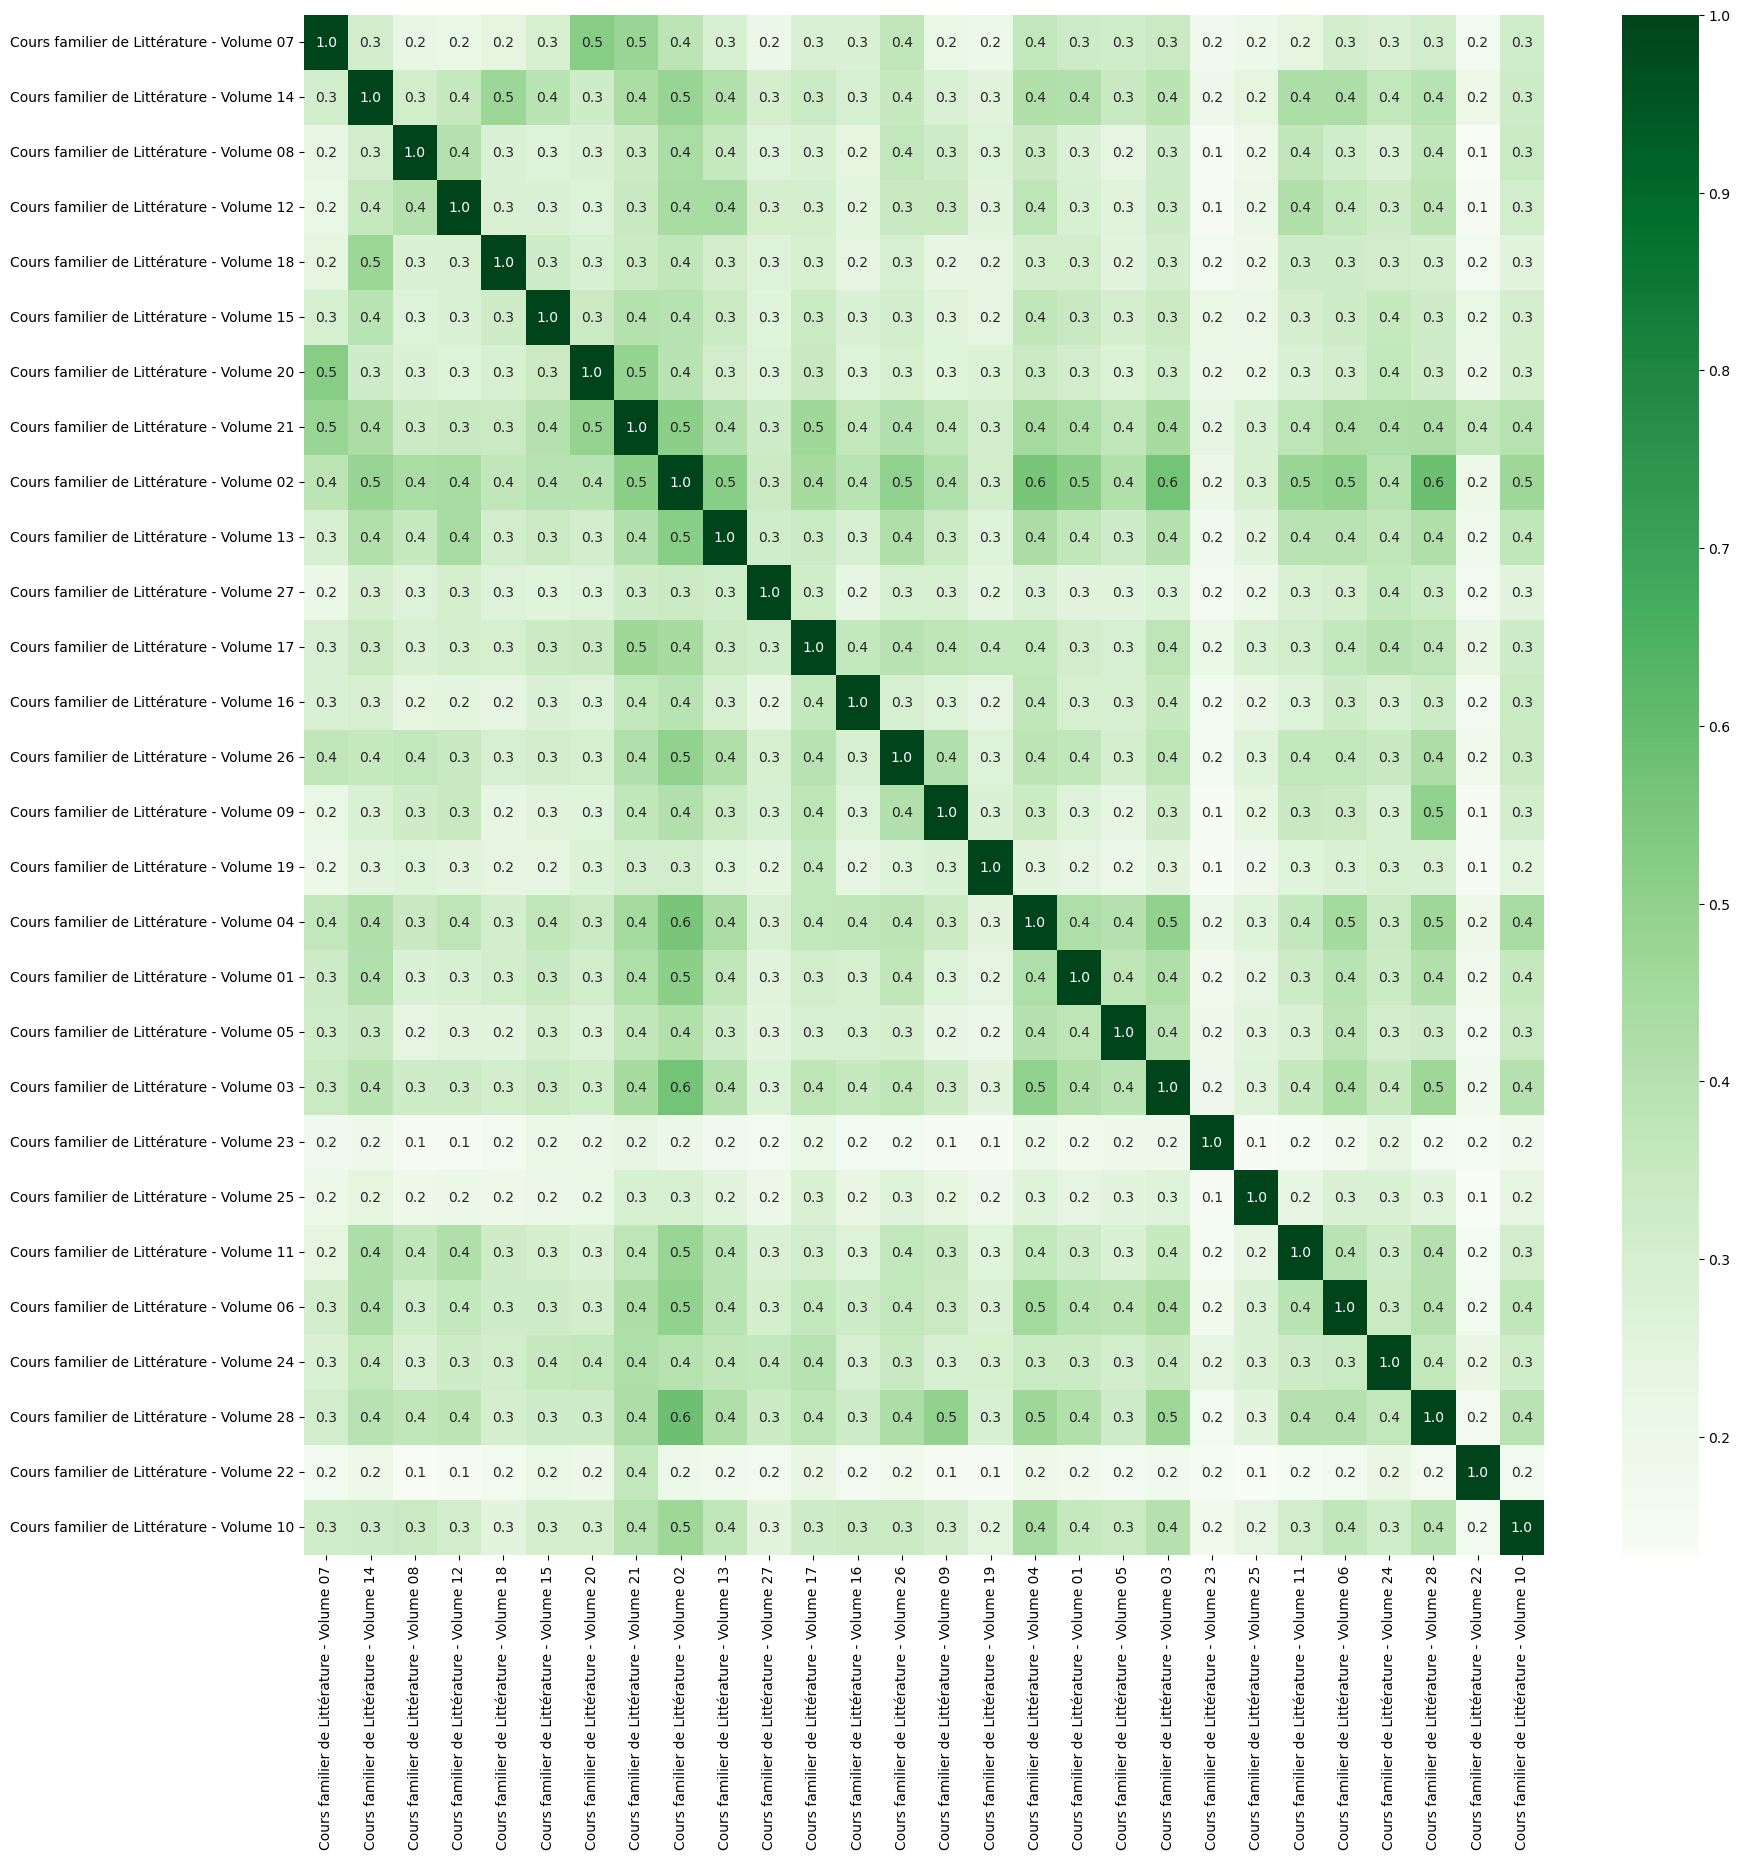

No duplicates

Anatole France


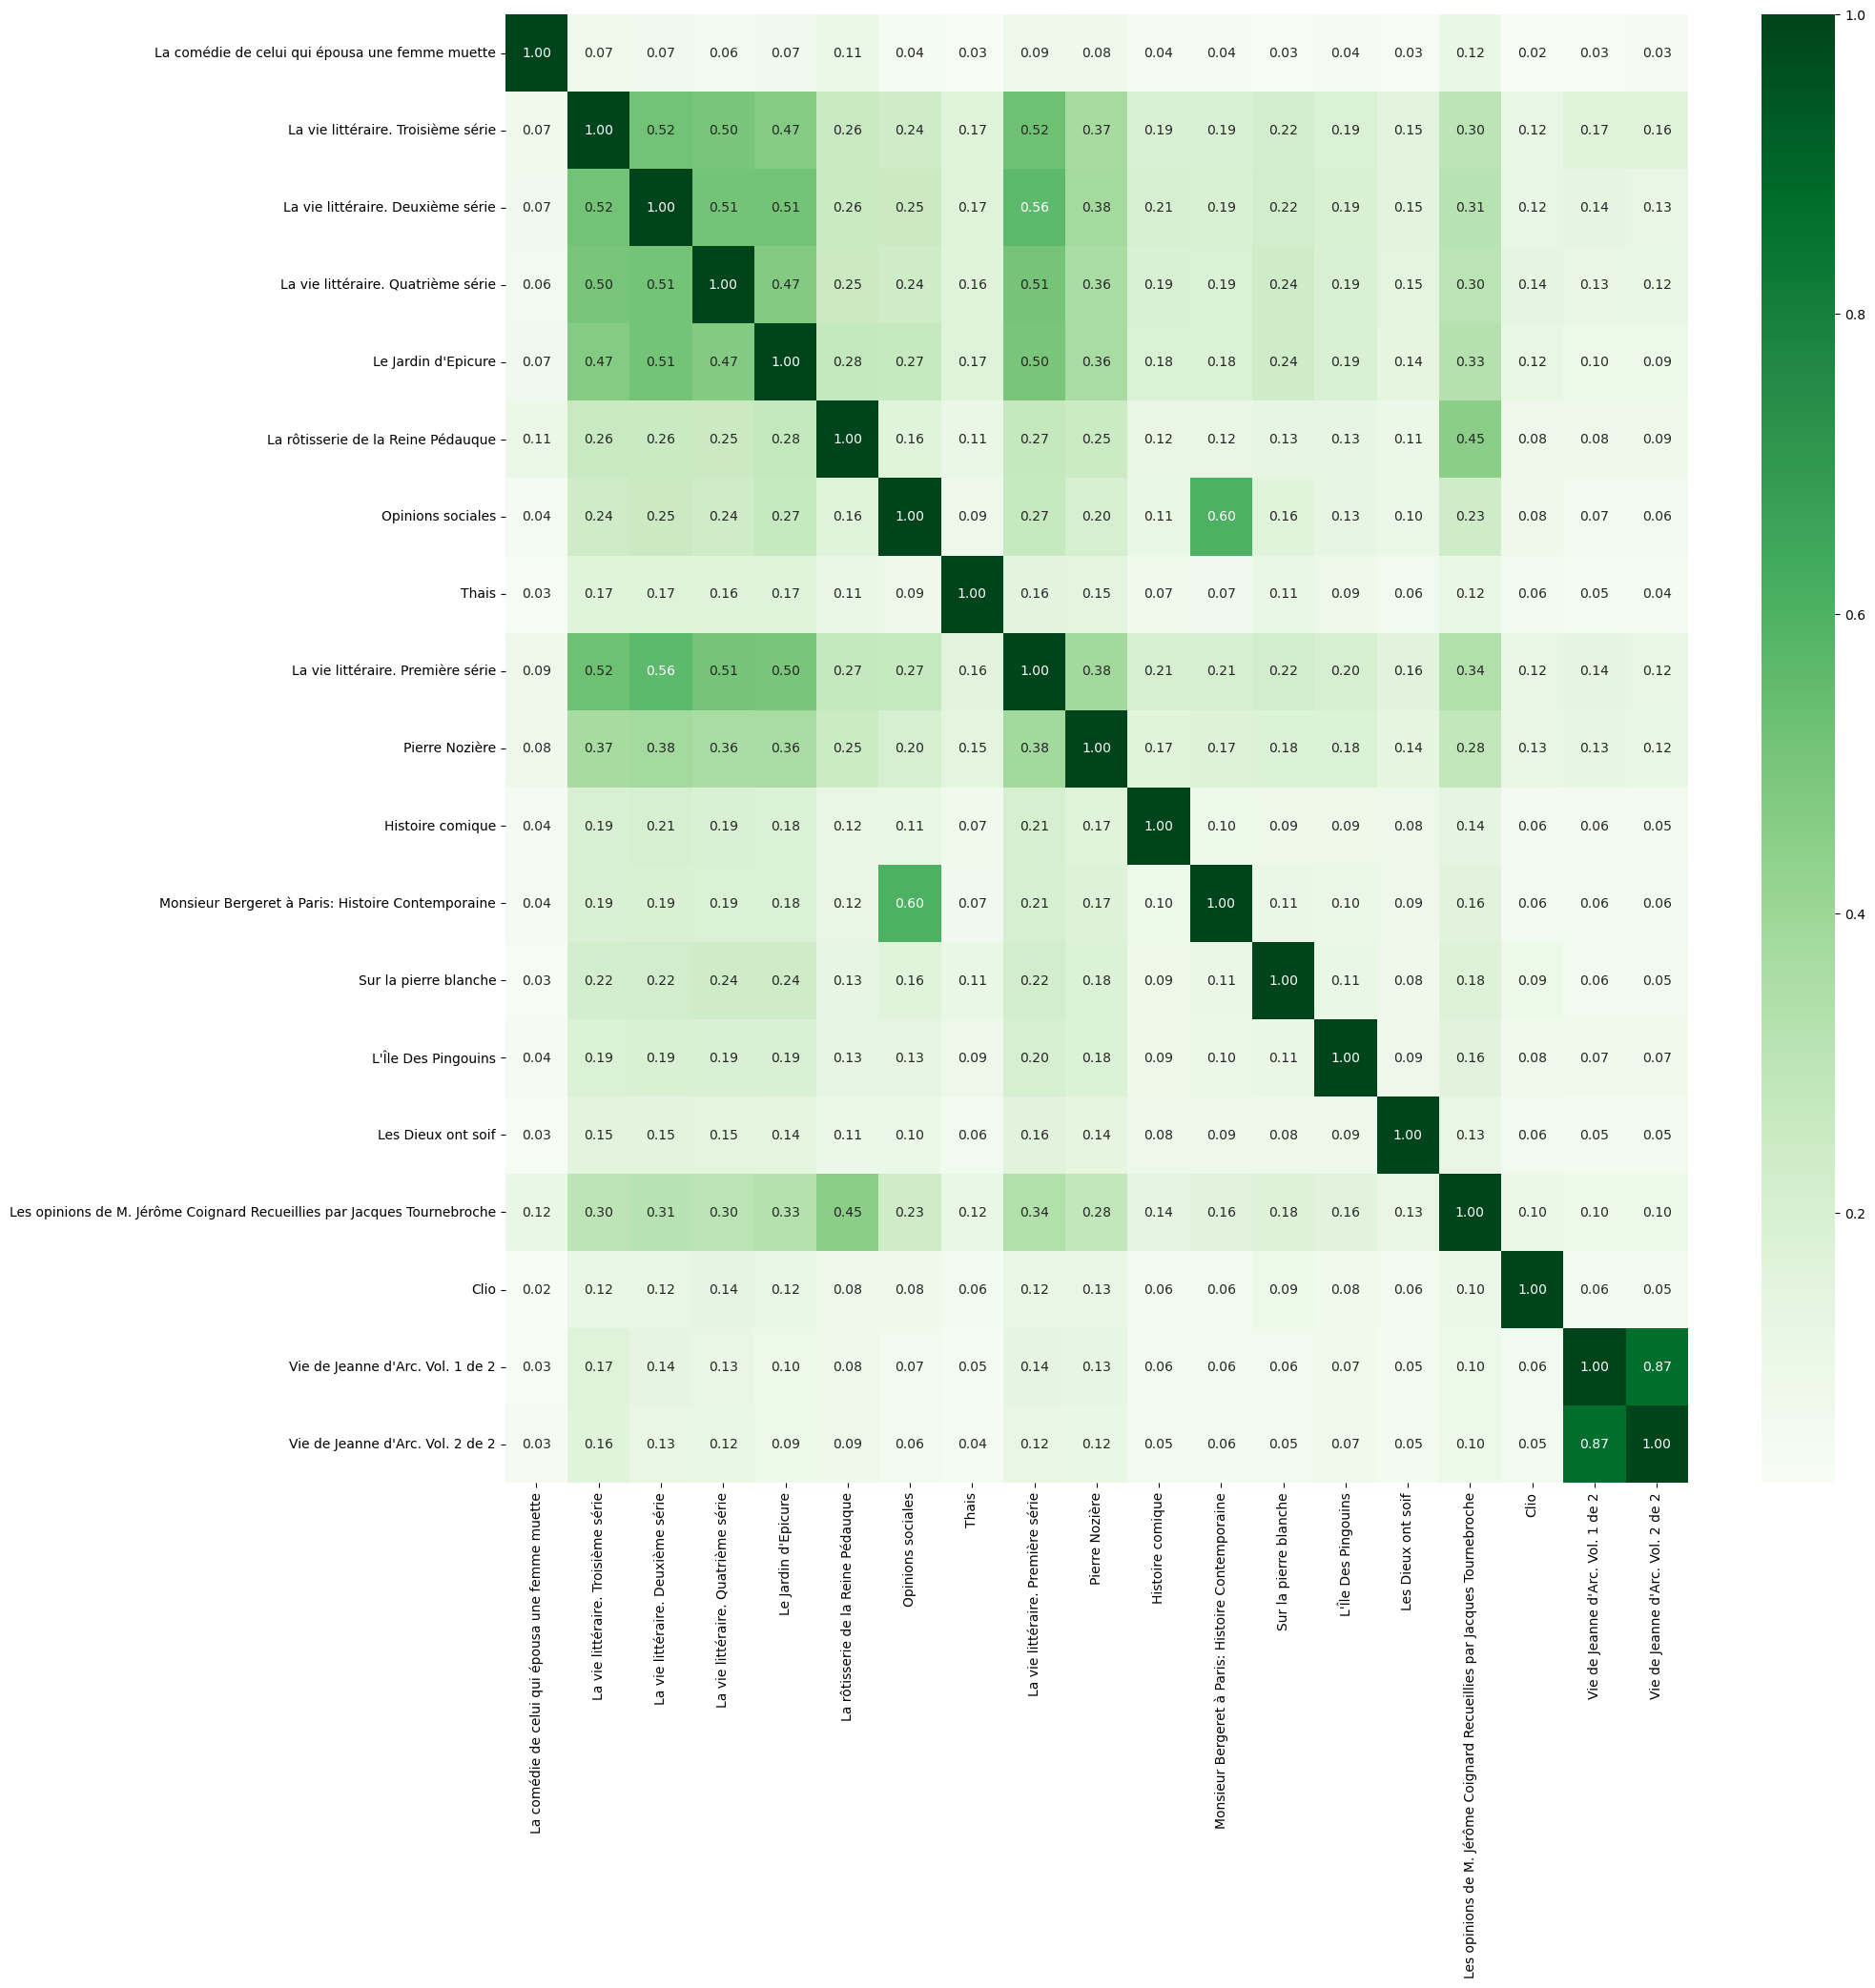

Possible duplicates:

Vie de Jeanne d'Arc. Vol. 2 de 2 (33693) and
Vie de Jeanne d'Arc. Vol. 1 de 2 (33692)


George Sand


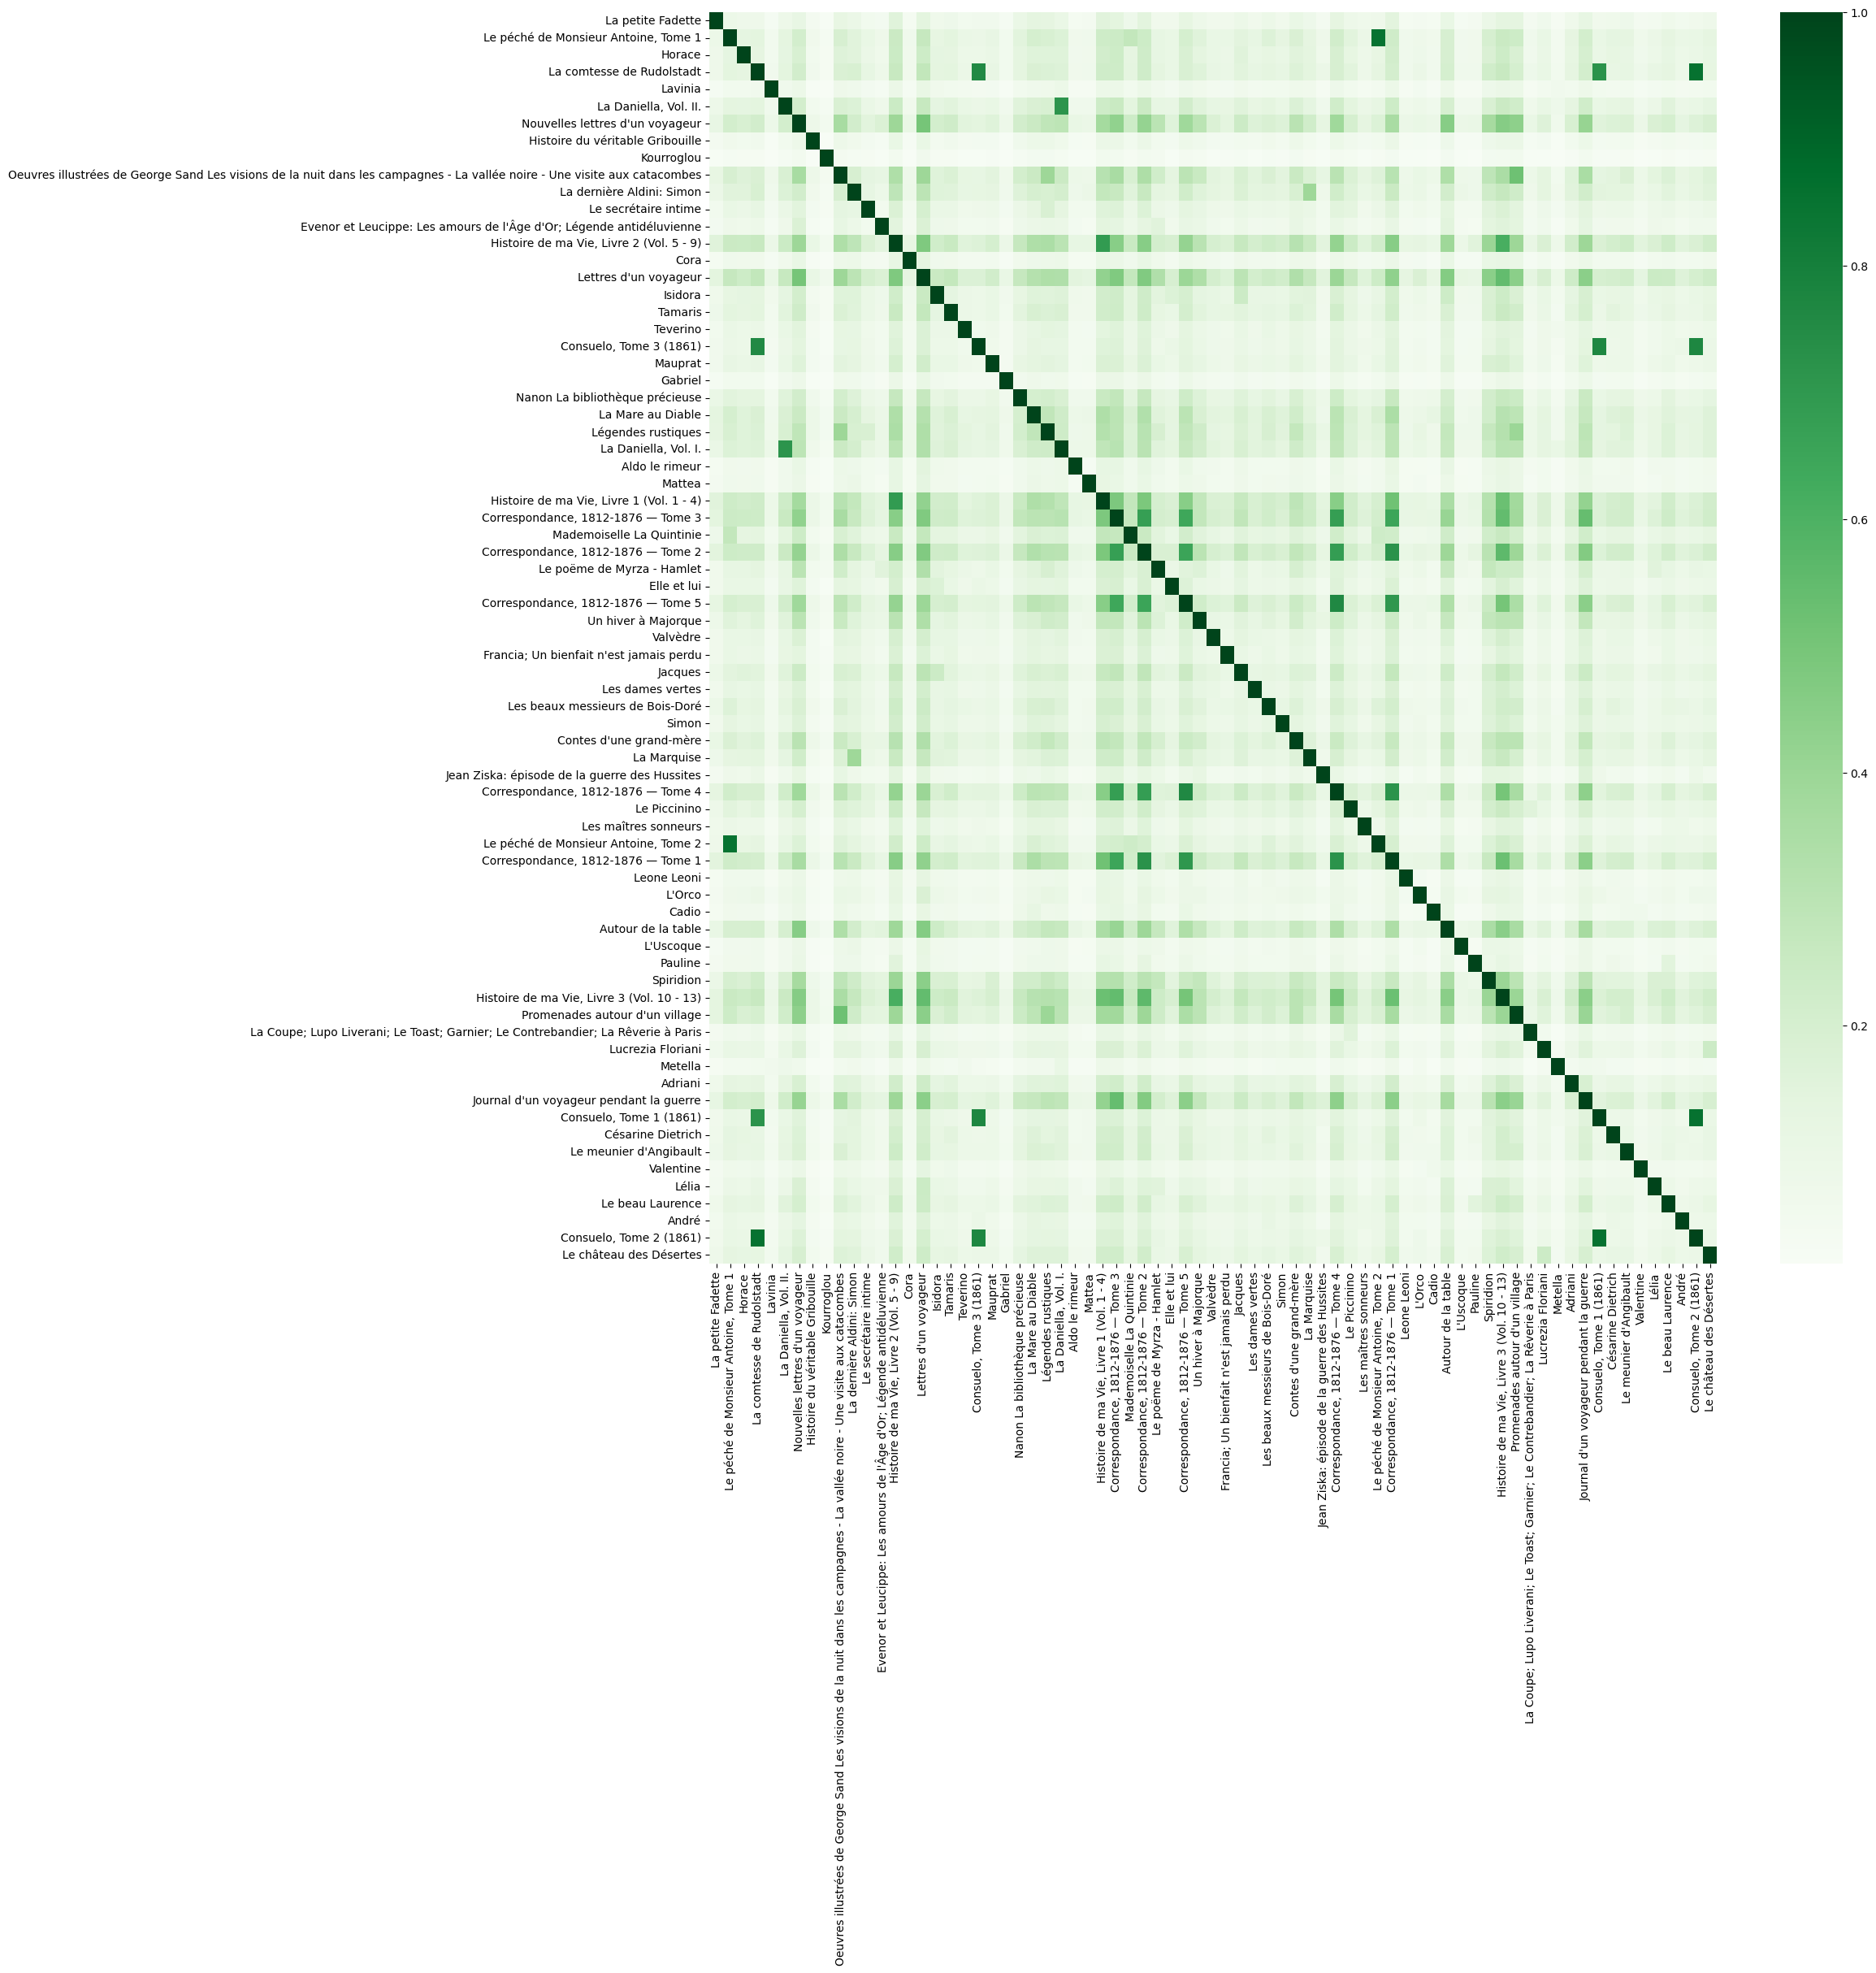

Possible duplicates:

Consuelo, Tome 3 (1861) (13374) and
La comtesse de Rudolstadt (17225)


Correspondance, 1812-1876 — Tome 4 (13875) and
Correspondance, 1812-1876 — Tome 5 (13839)


Le péché de Monsieur Antoine, Tome 2 (12534) and
Le péché de Monsieur Antoine, Tome 1 (12367)


Consuelo, Tome 1 (1861) (12666) and
Consuelo, Tome 3 (1861) (13374)


Consuelo, Tome 2 (1861) (13258) and
La comtesse de Rudolstadt (17225)


Consuelo, Tome 2 (1861) (13258) and
Consuelo, Tome 3 (1861) (13374)


Consuelo, Tome 2 (1861) (13258) and
Consuelo, Tome 1 (1861) (12666)


Gustave Flaubert


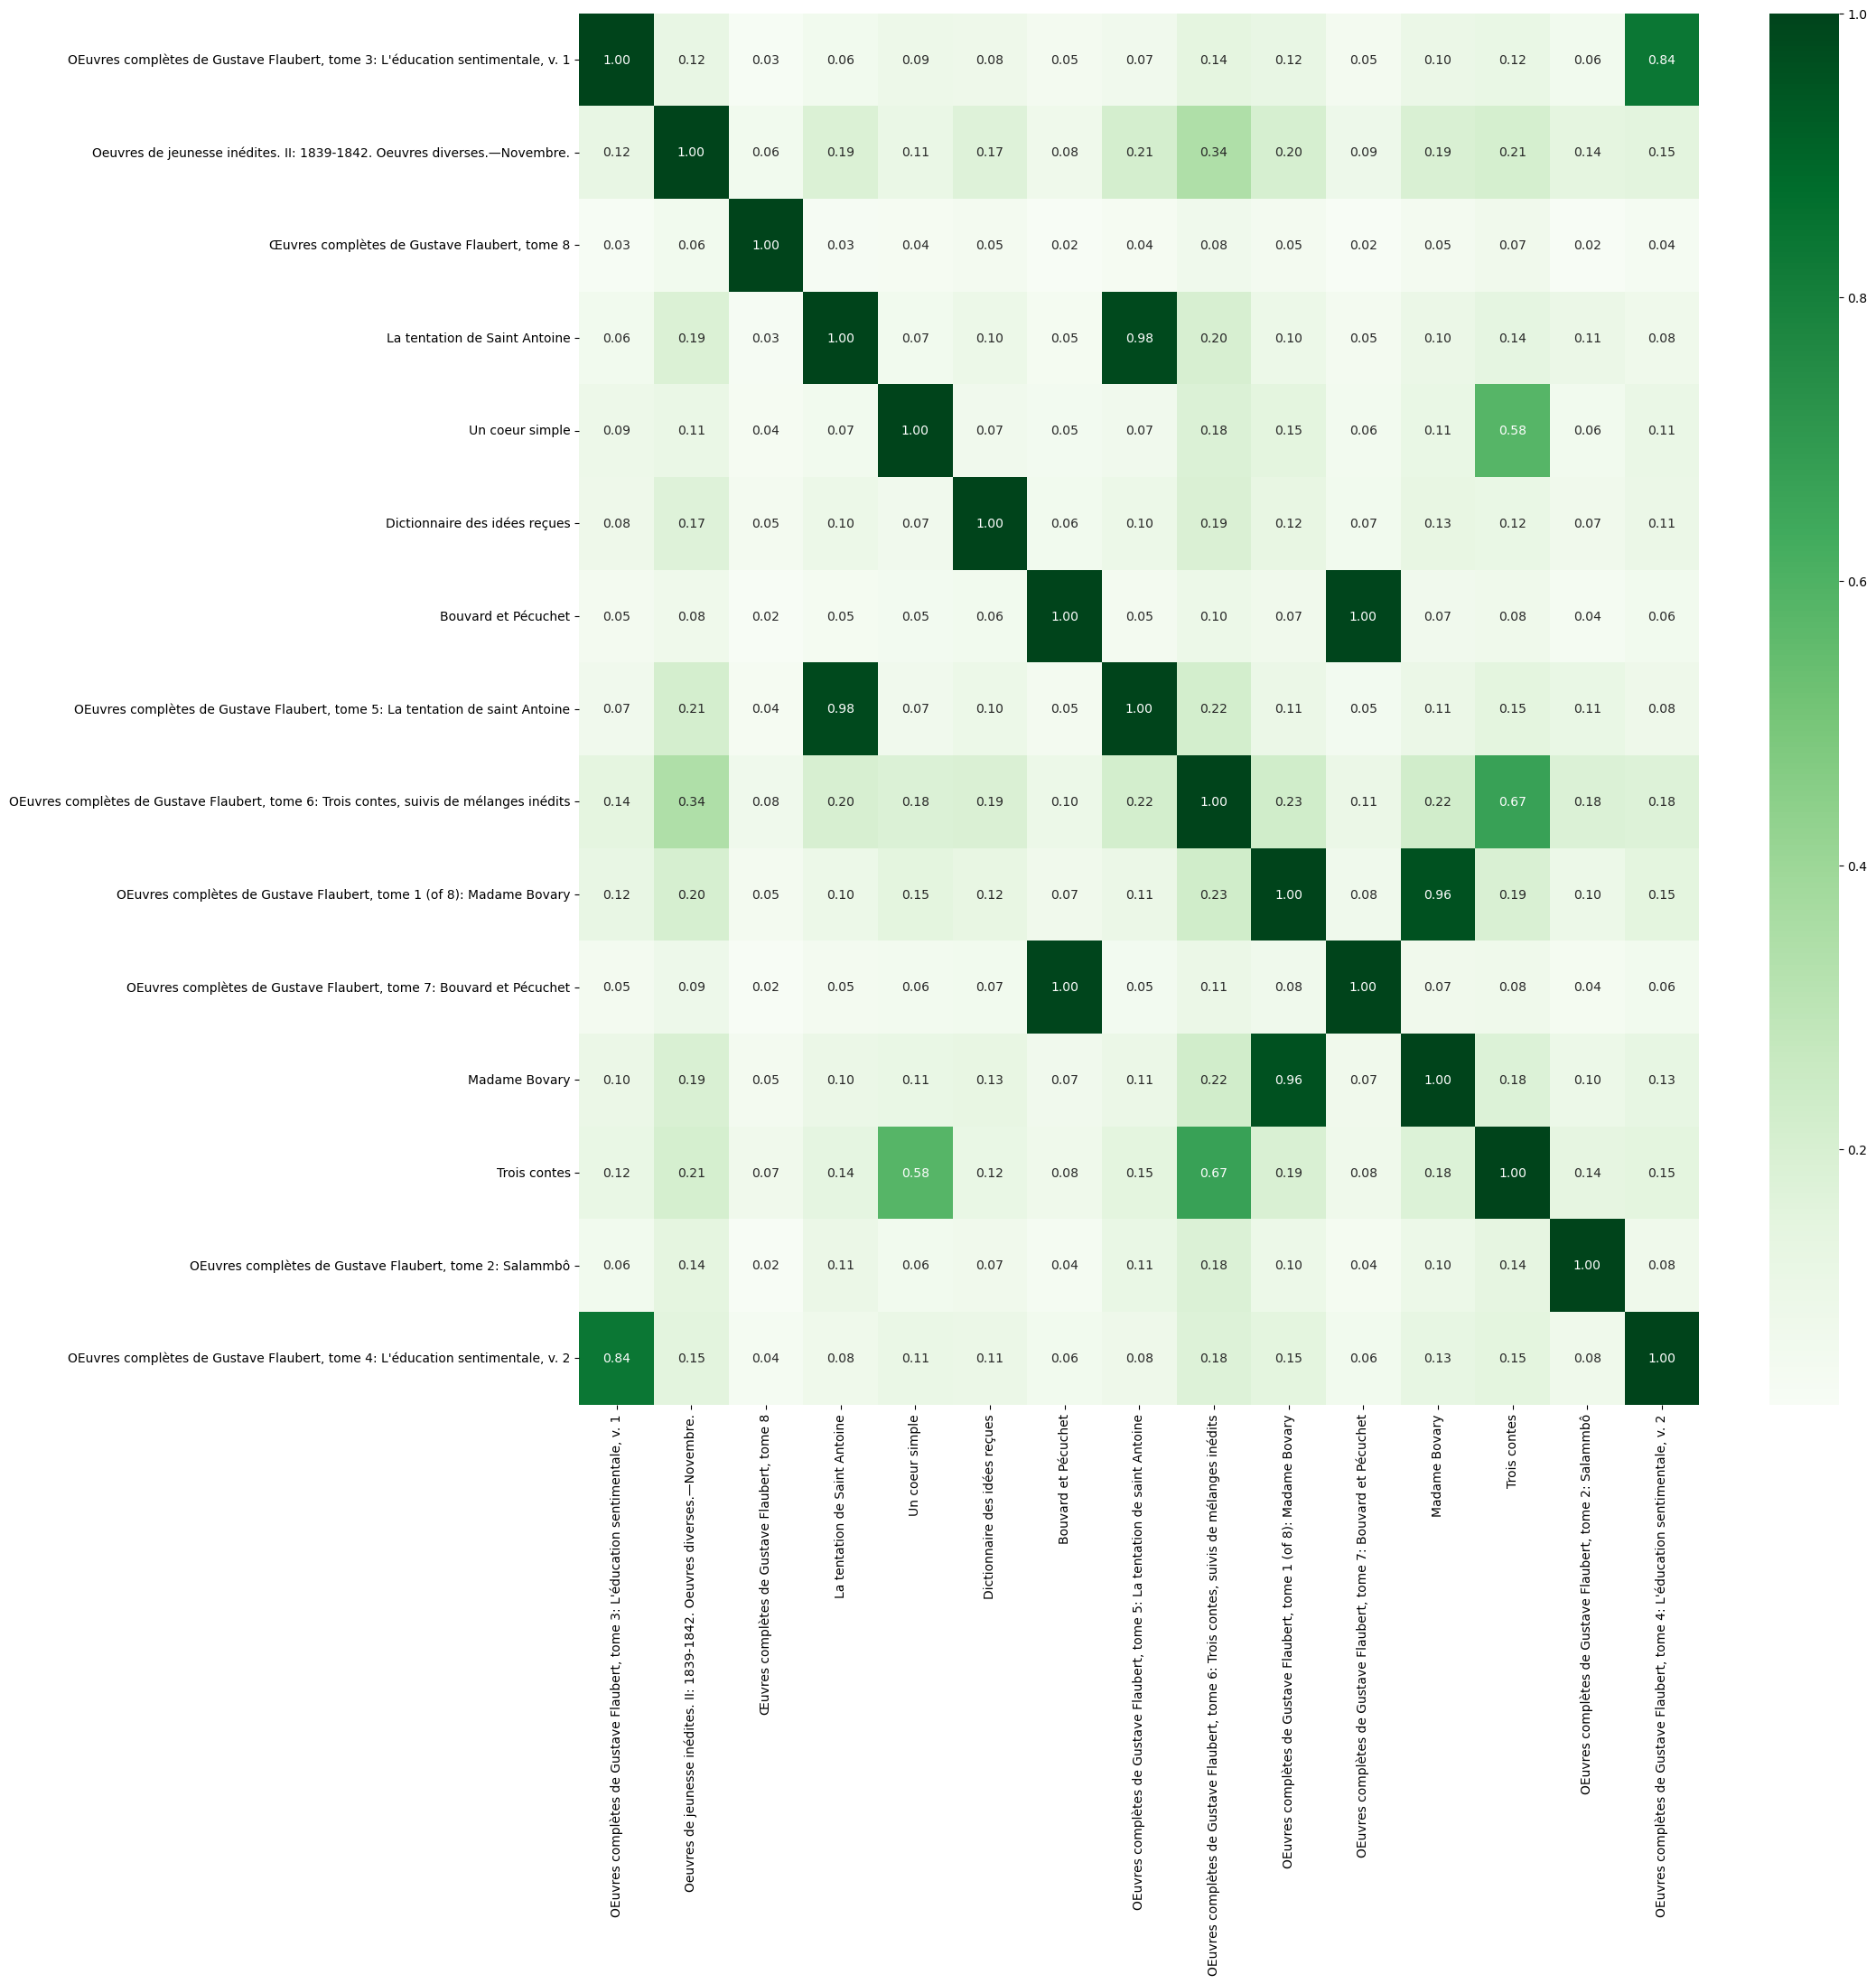

Possible duplicates:

OEuvres complètes de Gustave Flaubert, tome 5: La tentation de saint Antoine (57373) and
La tentation de Saint Antoine (10982)


OEuvres complètes de Gustave Flaubert, tome 7: Bouvard et Pécuchet (66505) and
Bouvard et Pécuchet (14157)


Madame Bovary (14155) and
OEuvres complètes de Gustave Flaubert, tome 1 (of 8): Madame Bovary (48359)


OEuvres complètes de Gustave Flaubert, tome 4: L'éducation sentimentale, v. 2 (52893) and
OEuvres complètes de Gustave Flaubert, tome 3: L'éducation sentimentale, v. 1 (49773)


Guy de Maupassant


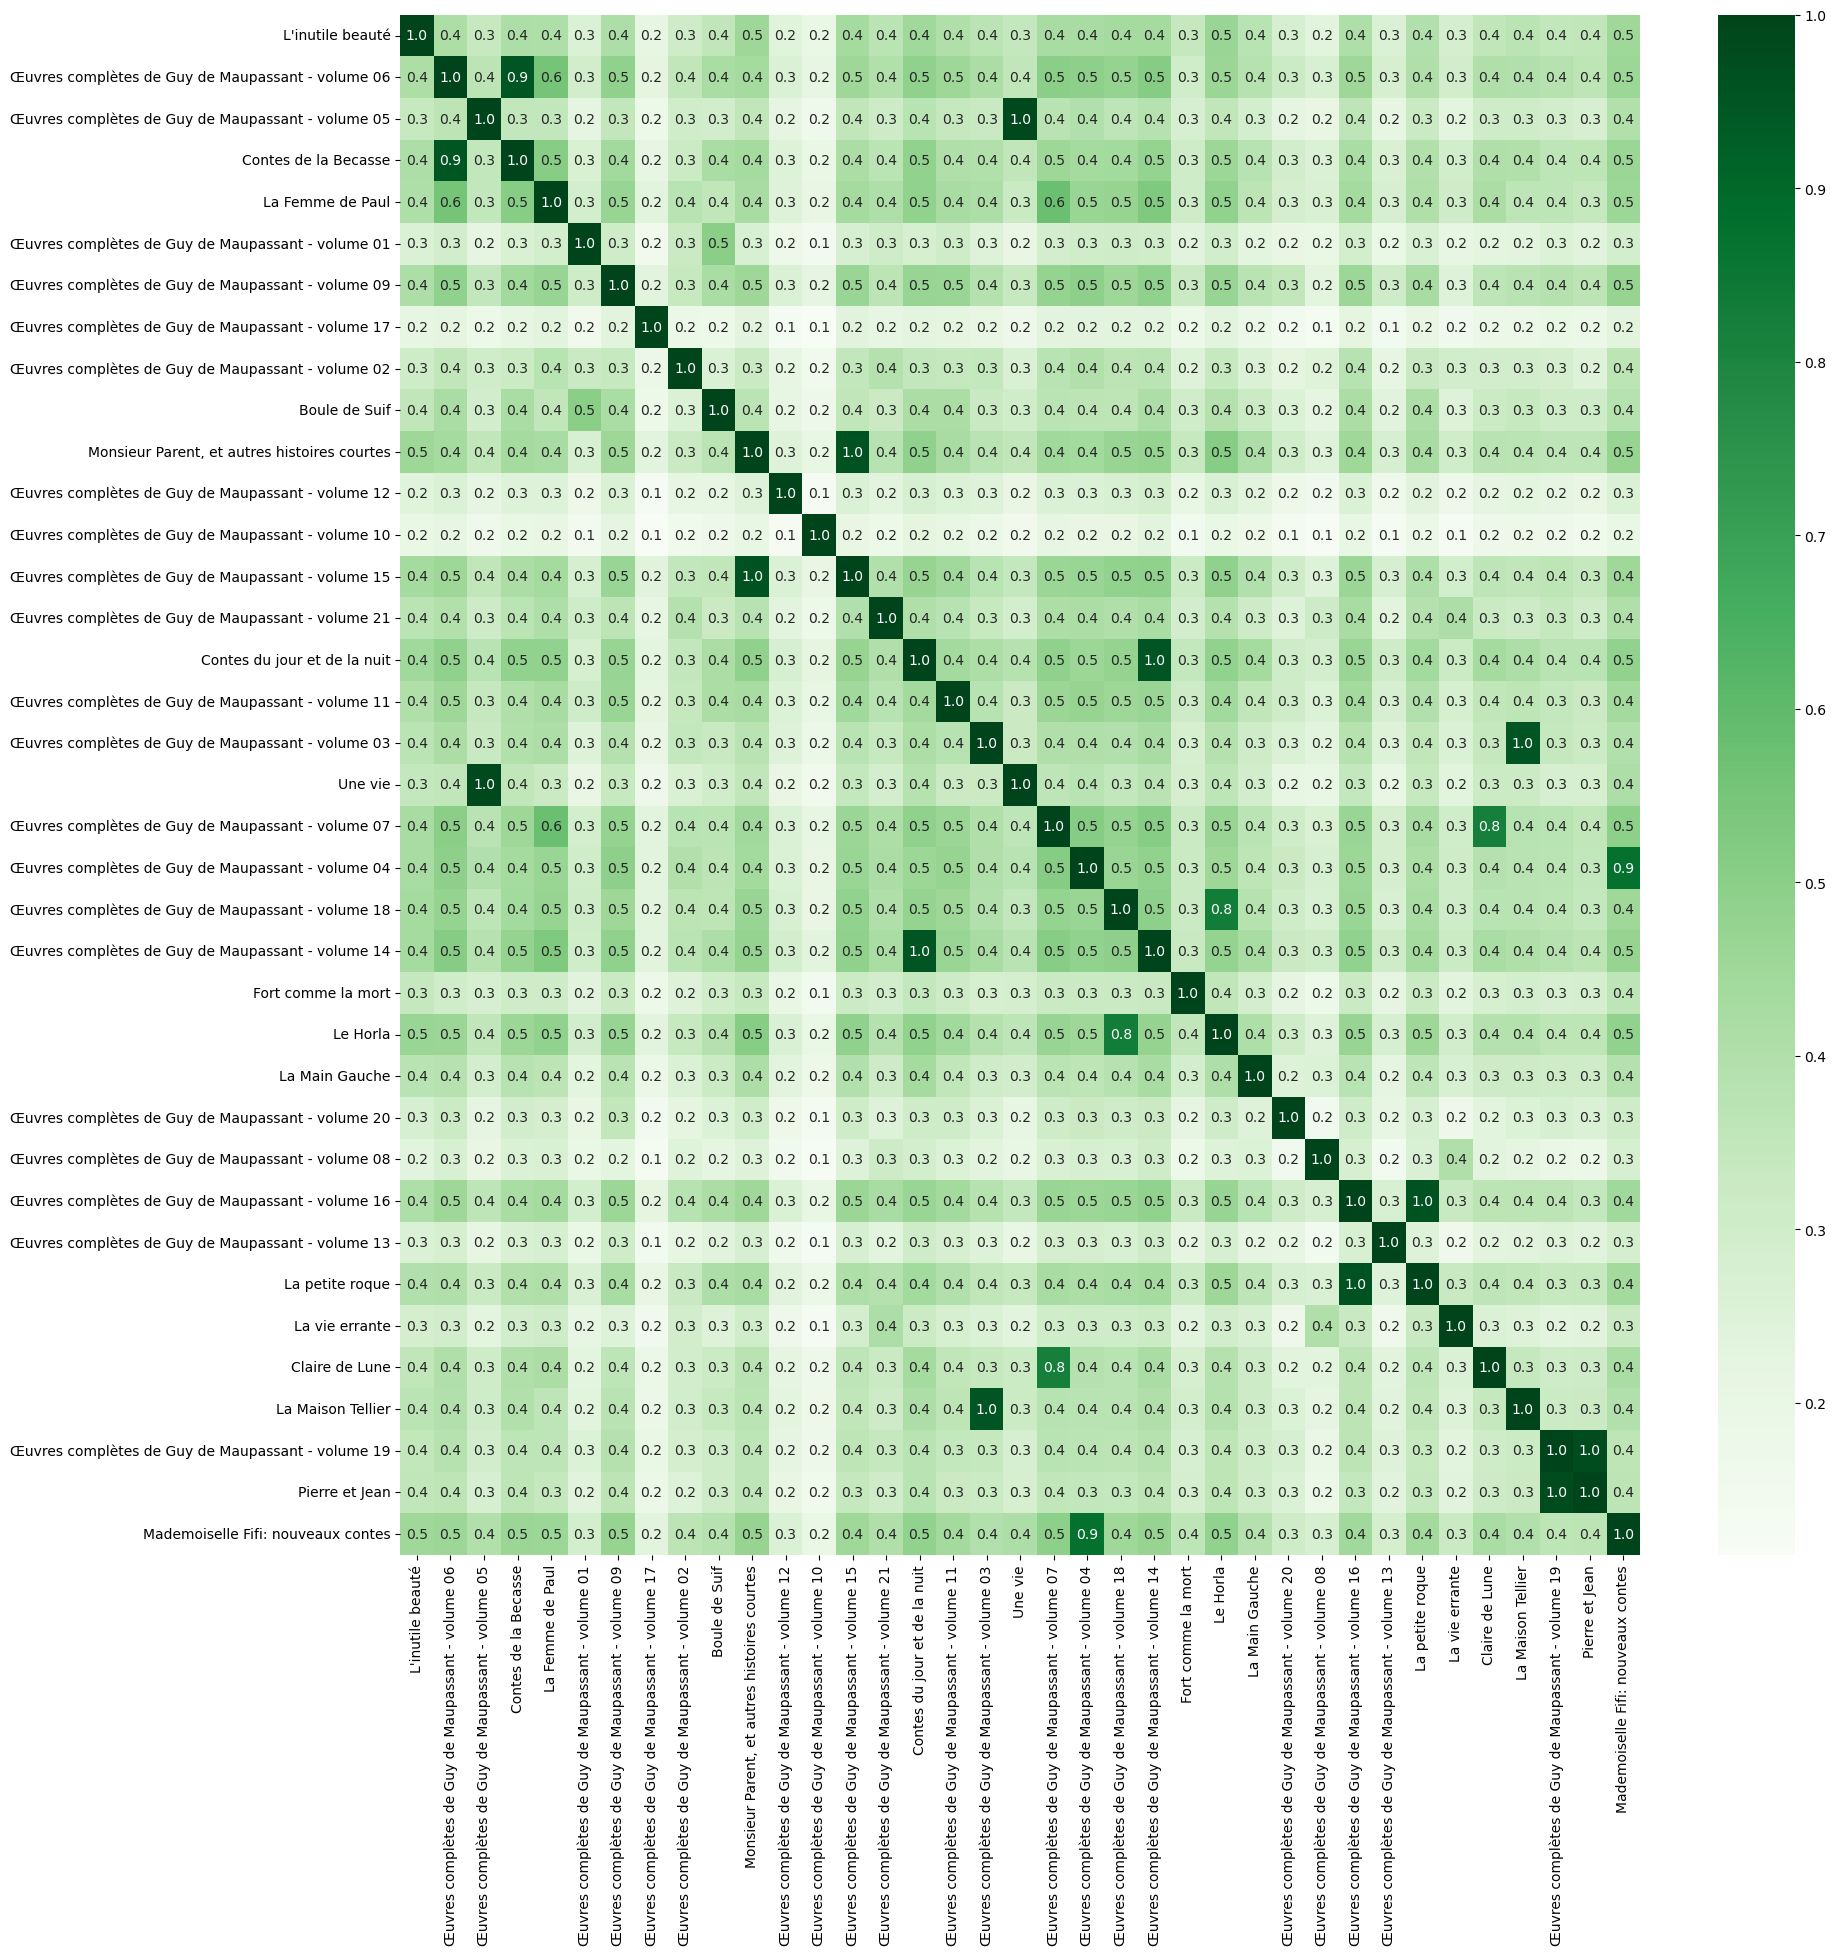

Possible duplicates:

Contes de la Becasse (11714) and
Œuvres complètes de Guy de Maupassant - volume 06 (51266)


Œuvres complètes de Guy de Maupassant - volume 15 (60610) and
Monsieur Parent, et autres histoires courtes (12011)


Une vie (17457) and
Œuvres complètes de Guy de Maupassant - volume 05 (50144)


Œuvres complètes de Guy de Maupassant - volume 14 (57567) and
Contes du jour et de la nuit (14790)


Le Horla (10775) and
Œuvres complètes de Guy de Maupassant - volume 18 (67158)


La petite roque (18353) and
Œuvres complètes de Guy de Maupassant - volume 16 (67024)


Claire de Lune (11199) and
Œuvres complètes de Guy de Maupassant - volume 07 (51423)


La Maison Tellier (11596) and
Œuvres complètes de Guy de Maupassant - volume 03 (46387)


Pierre et Jean (11131) and
Œuvres complètes de Guy de Maupassant - volume 19 (67940)


Mademoiselle Fifi: nouveaux contes (11597) and
Œuvres complètes de Guy de Maupassant - volume 04 (46470)


Jules Verne


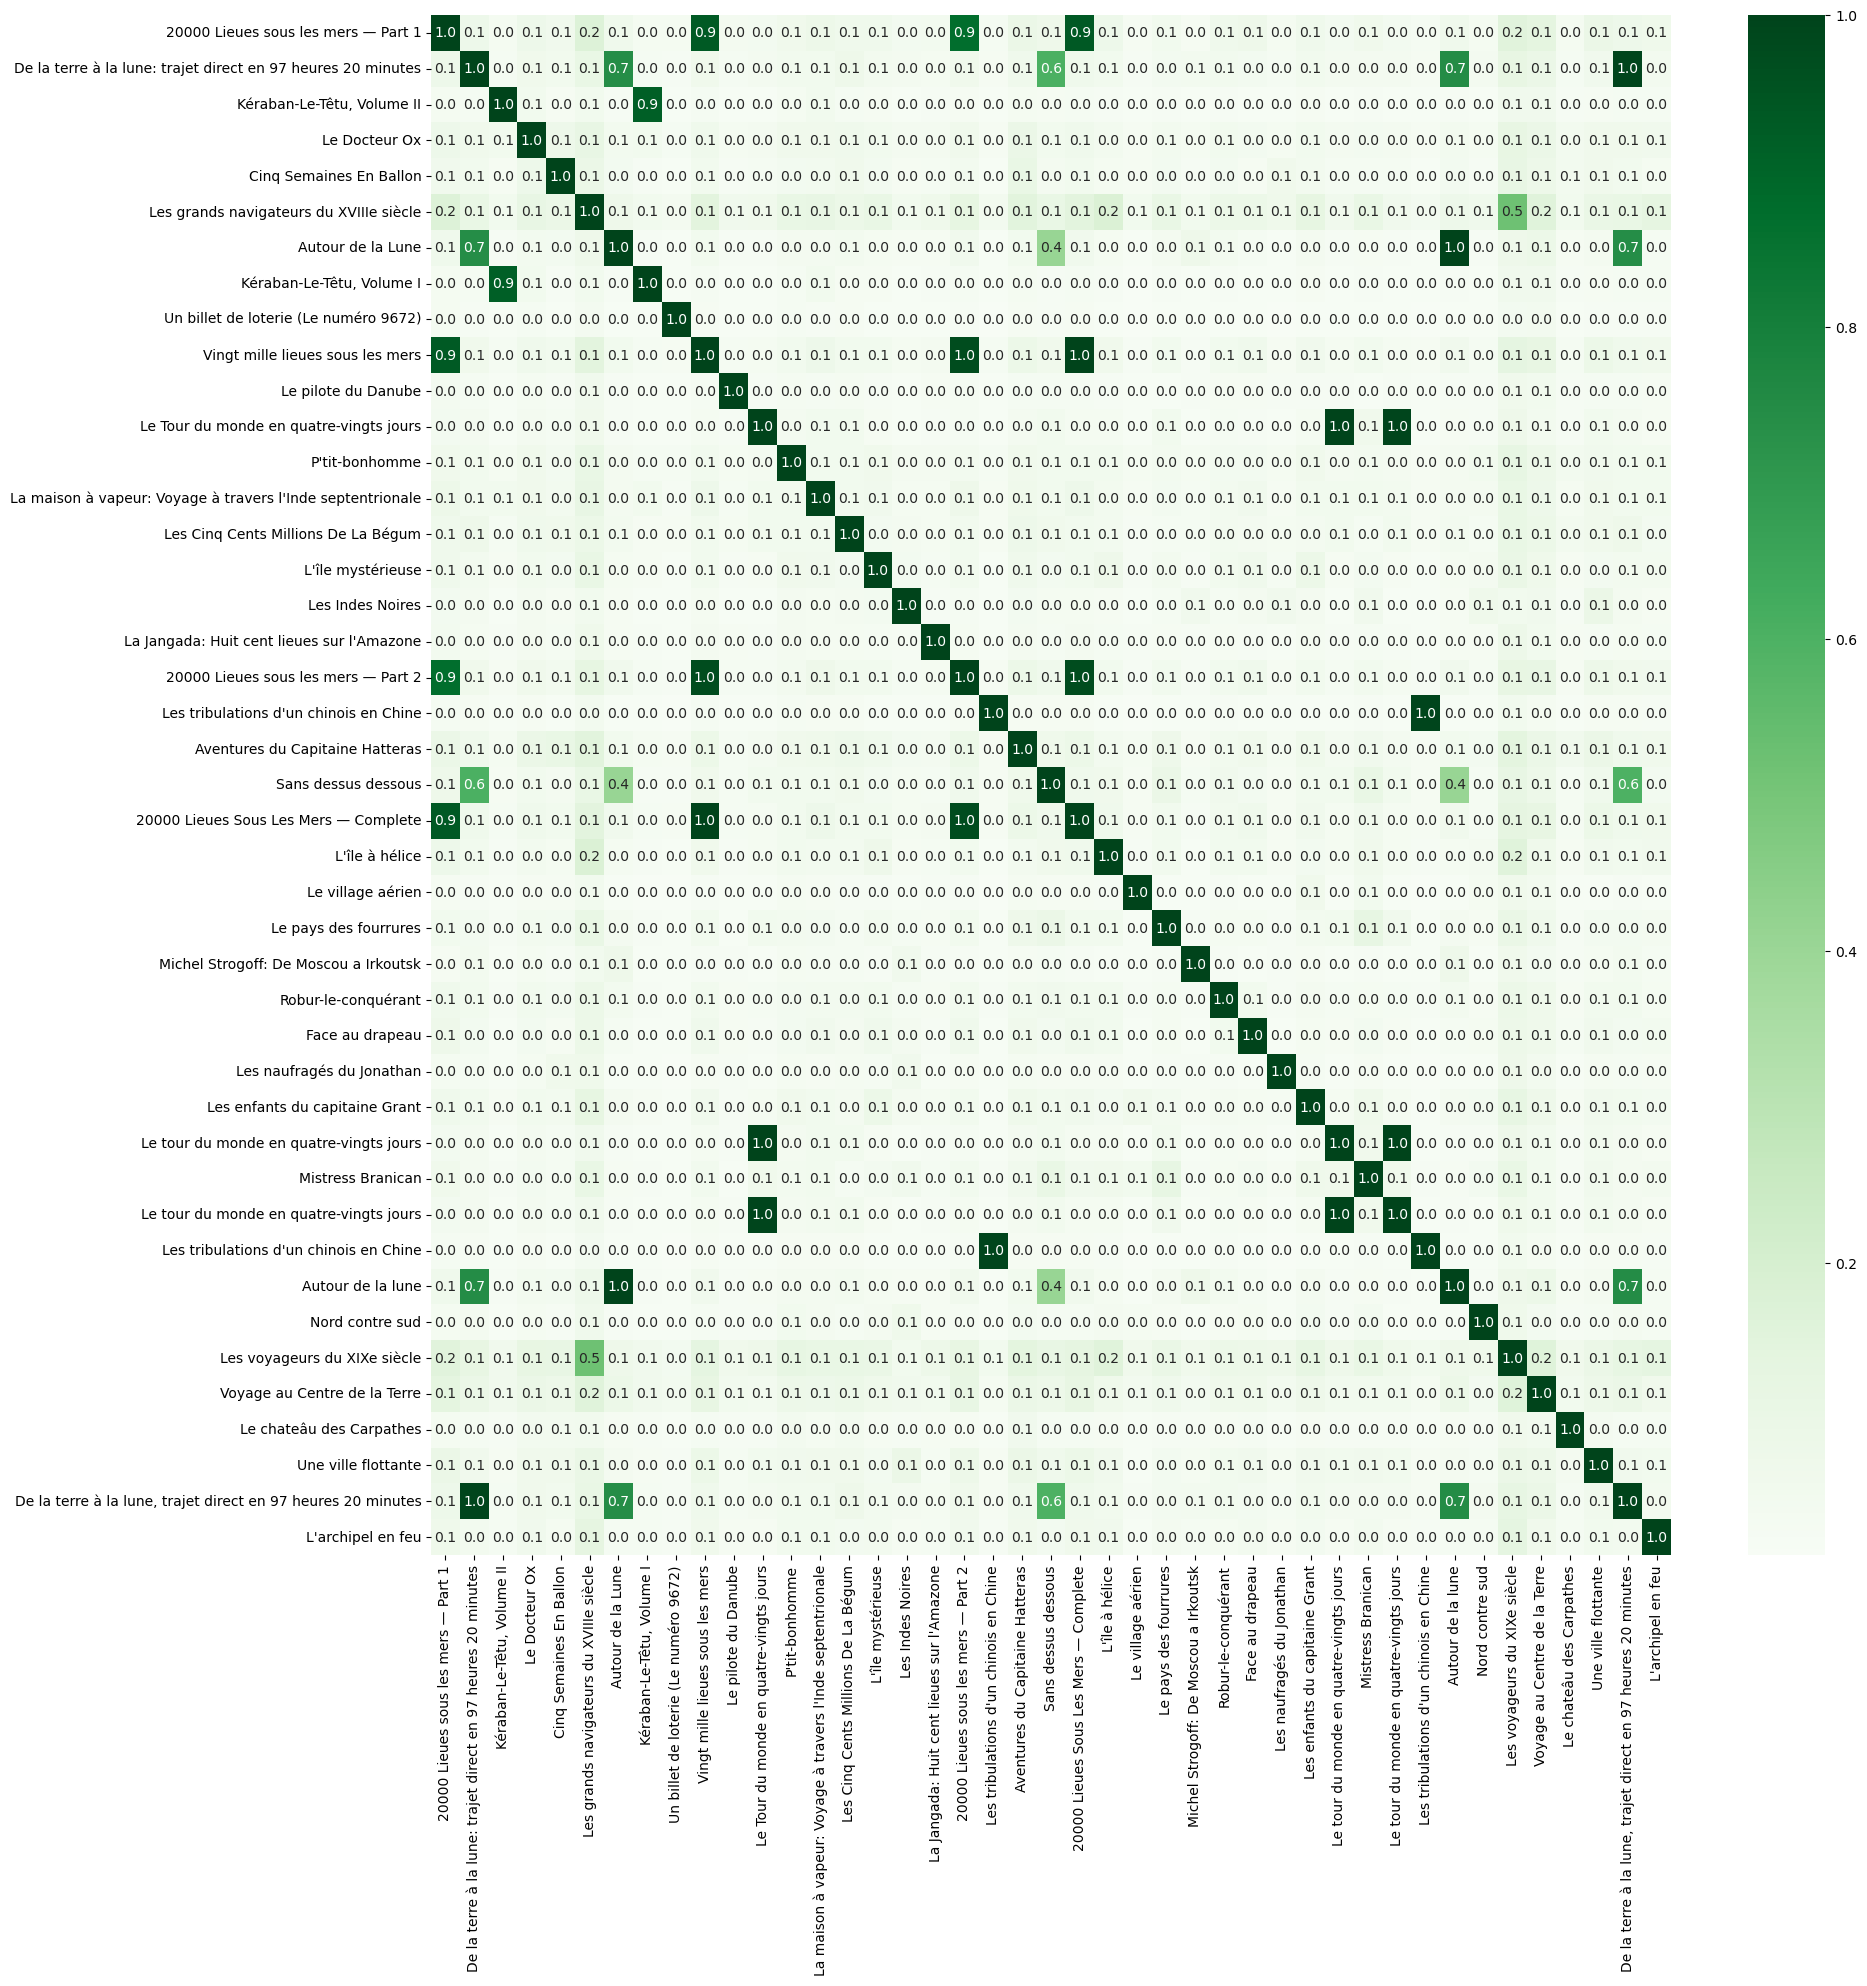

Possible duplicates:

Kéraban-Le-Têtu, Volume I (8174) and
Kéraban-Le-Têtu, Volume II (8175)


Vingt mille lieues sous les mers (54873) and
20000 Lieues sous les mers — Part 1 (5095)


20000 Lieues sous les mers — Part 2 (5096) and
20000 Lieues sous les mers — Part 1 (5095)


20000 Lieues sous les mers — Part 2 (5096) and
Vingt mille lieues sous les mers (54873)


20000 Lieues Sous Les Mers — Complete (5097) and
20000 Lieues sous les mers — Part 1 (5095)


20000 Lieues Sous Les Mers — Complete (5097) and
Vingt mille lieues sous les mers (54873)


20000 Lieues Sous Les Mers — Complete (5097) and
20000 Lieues sous les mers — Part 2 (5096)


Le tour du monde en quatre-vingts jours (800) and
Le Tour du monde en quatre-vingts jours (46541)


Le tour du monde en quatre-vingts jours (3456) and
Le Tour du monde en quatre-vingts jours (46541)


Le tour du monde en quatre-vingts jours (3456) and
Le tour du monde en quatre-vingts jours (800)


Les tribulations d'un chinois en Chine (14162) and
Le

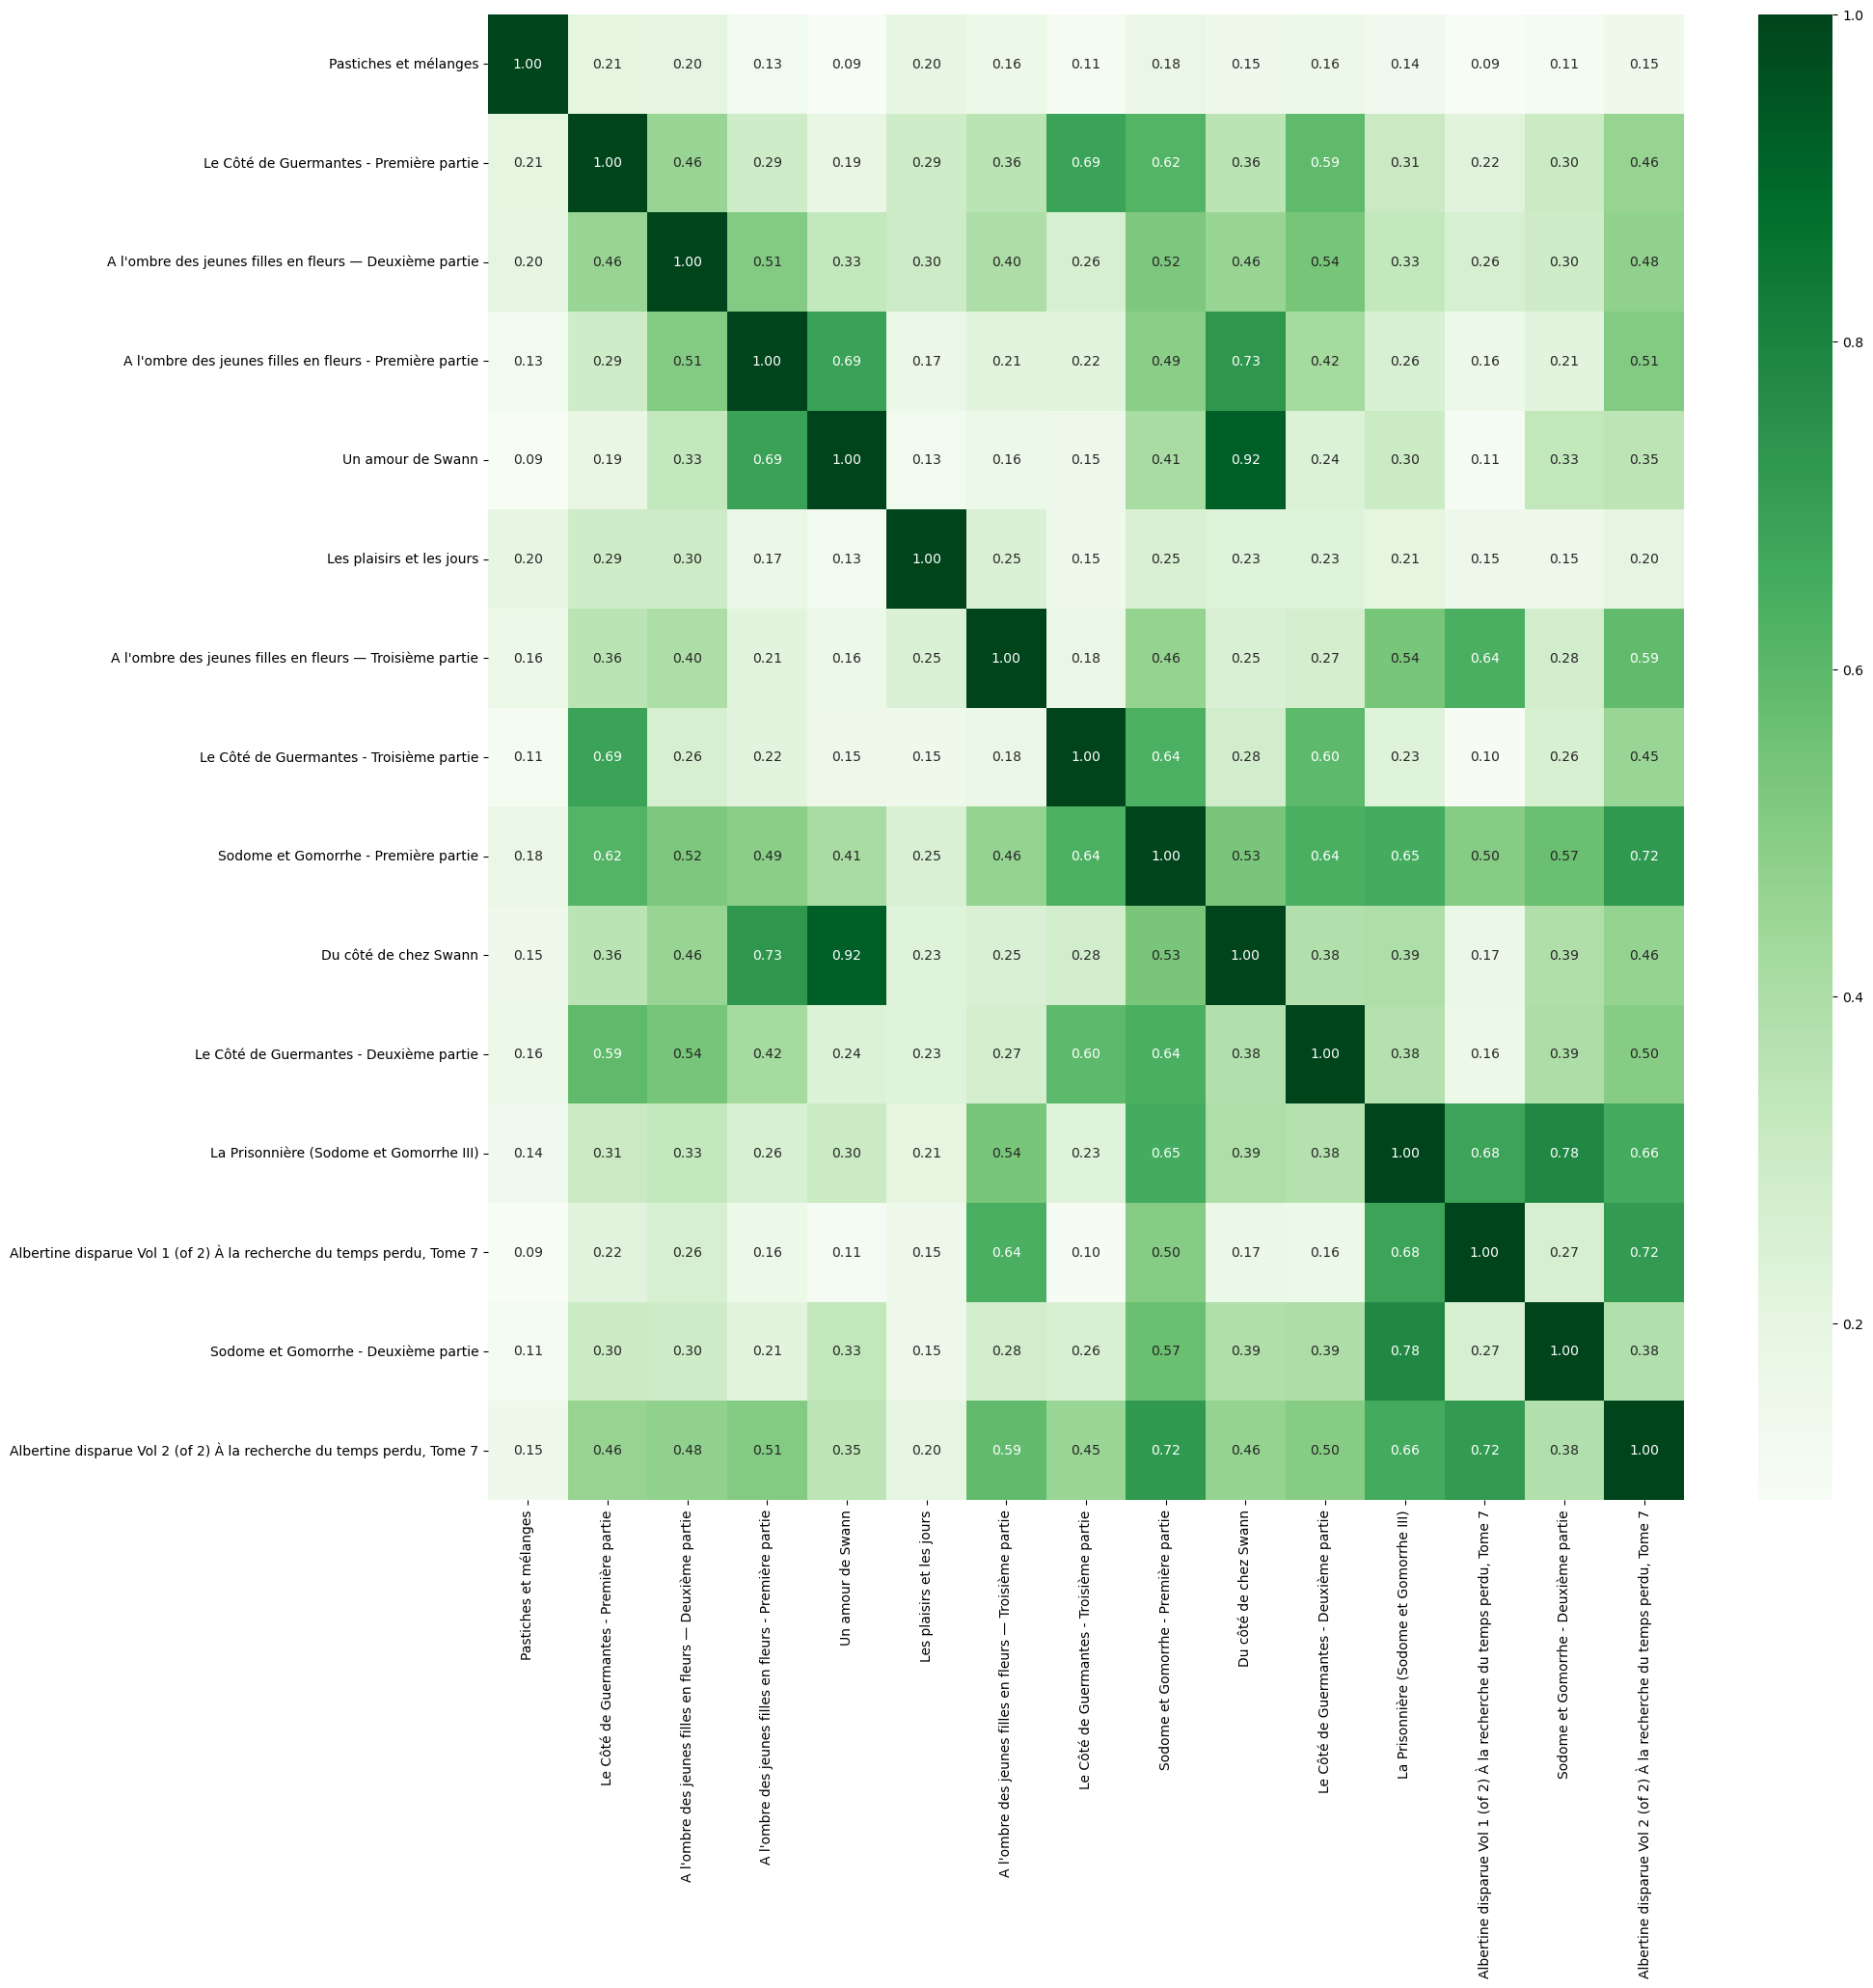

Possible duplicates:

Du côté de chez Swann (2650) and
Un amour de Swann (62100)


Sodome et Gomorrhe - Deuxième partie (15075) and
La Prisonnière (Sodome et Gomorrhe III) (60720)


Victor Hugo


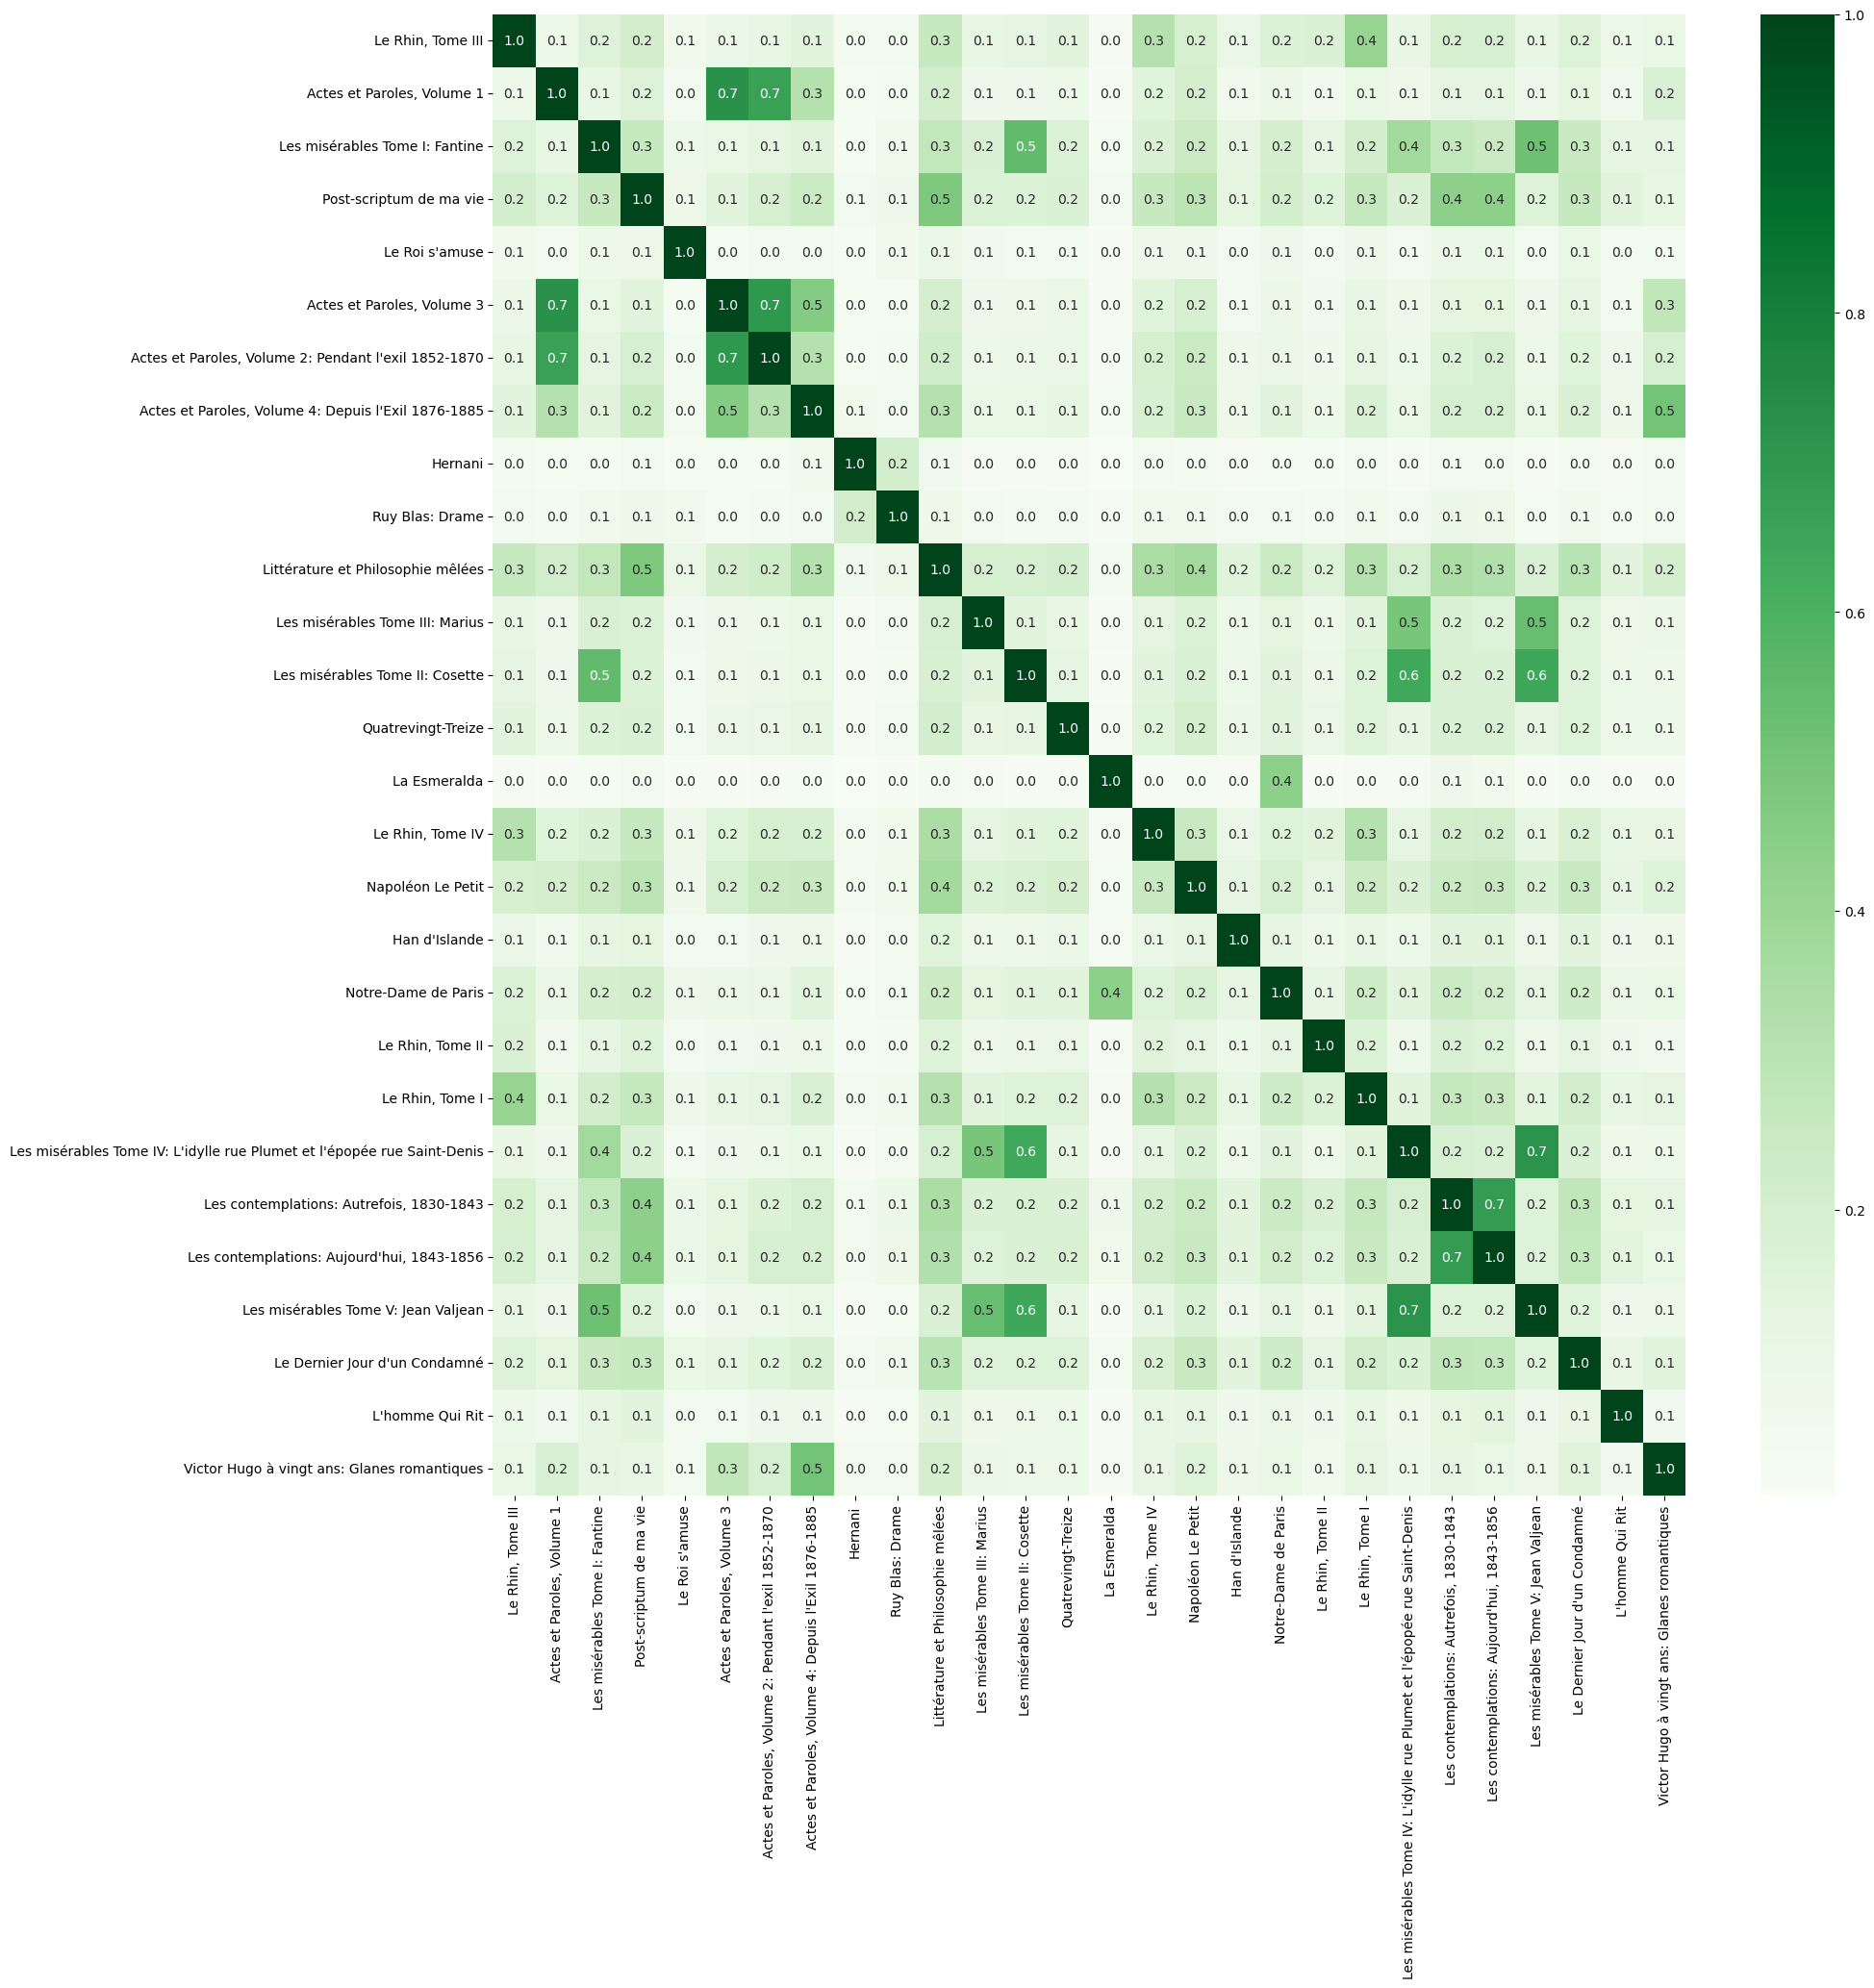

No duplicates

Émile Zola


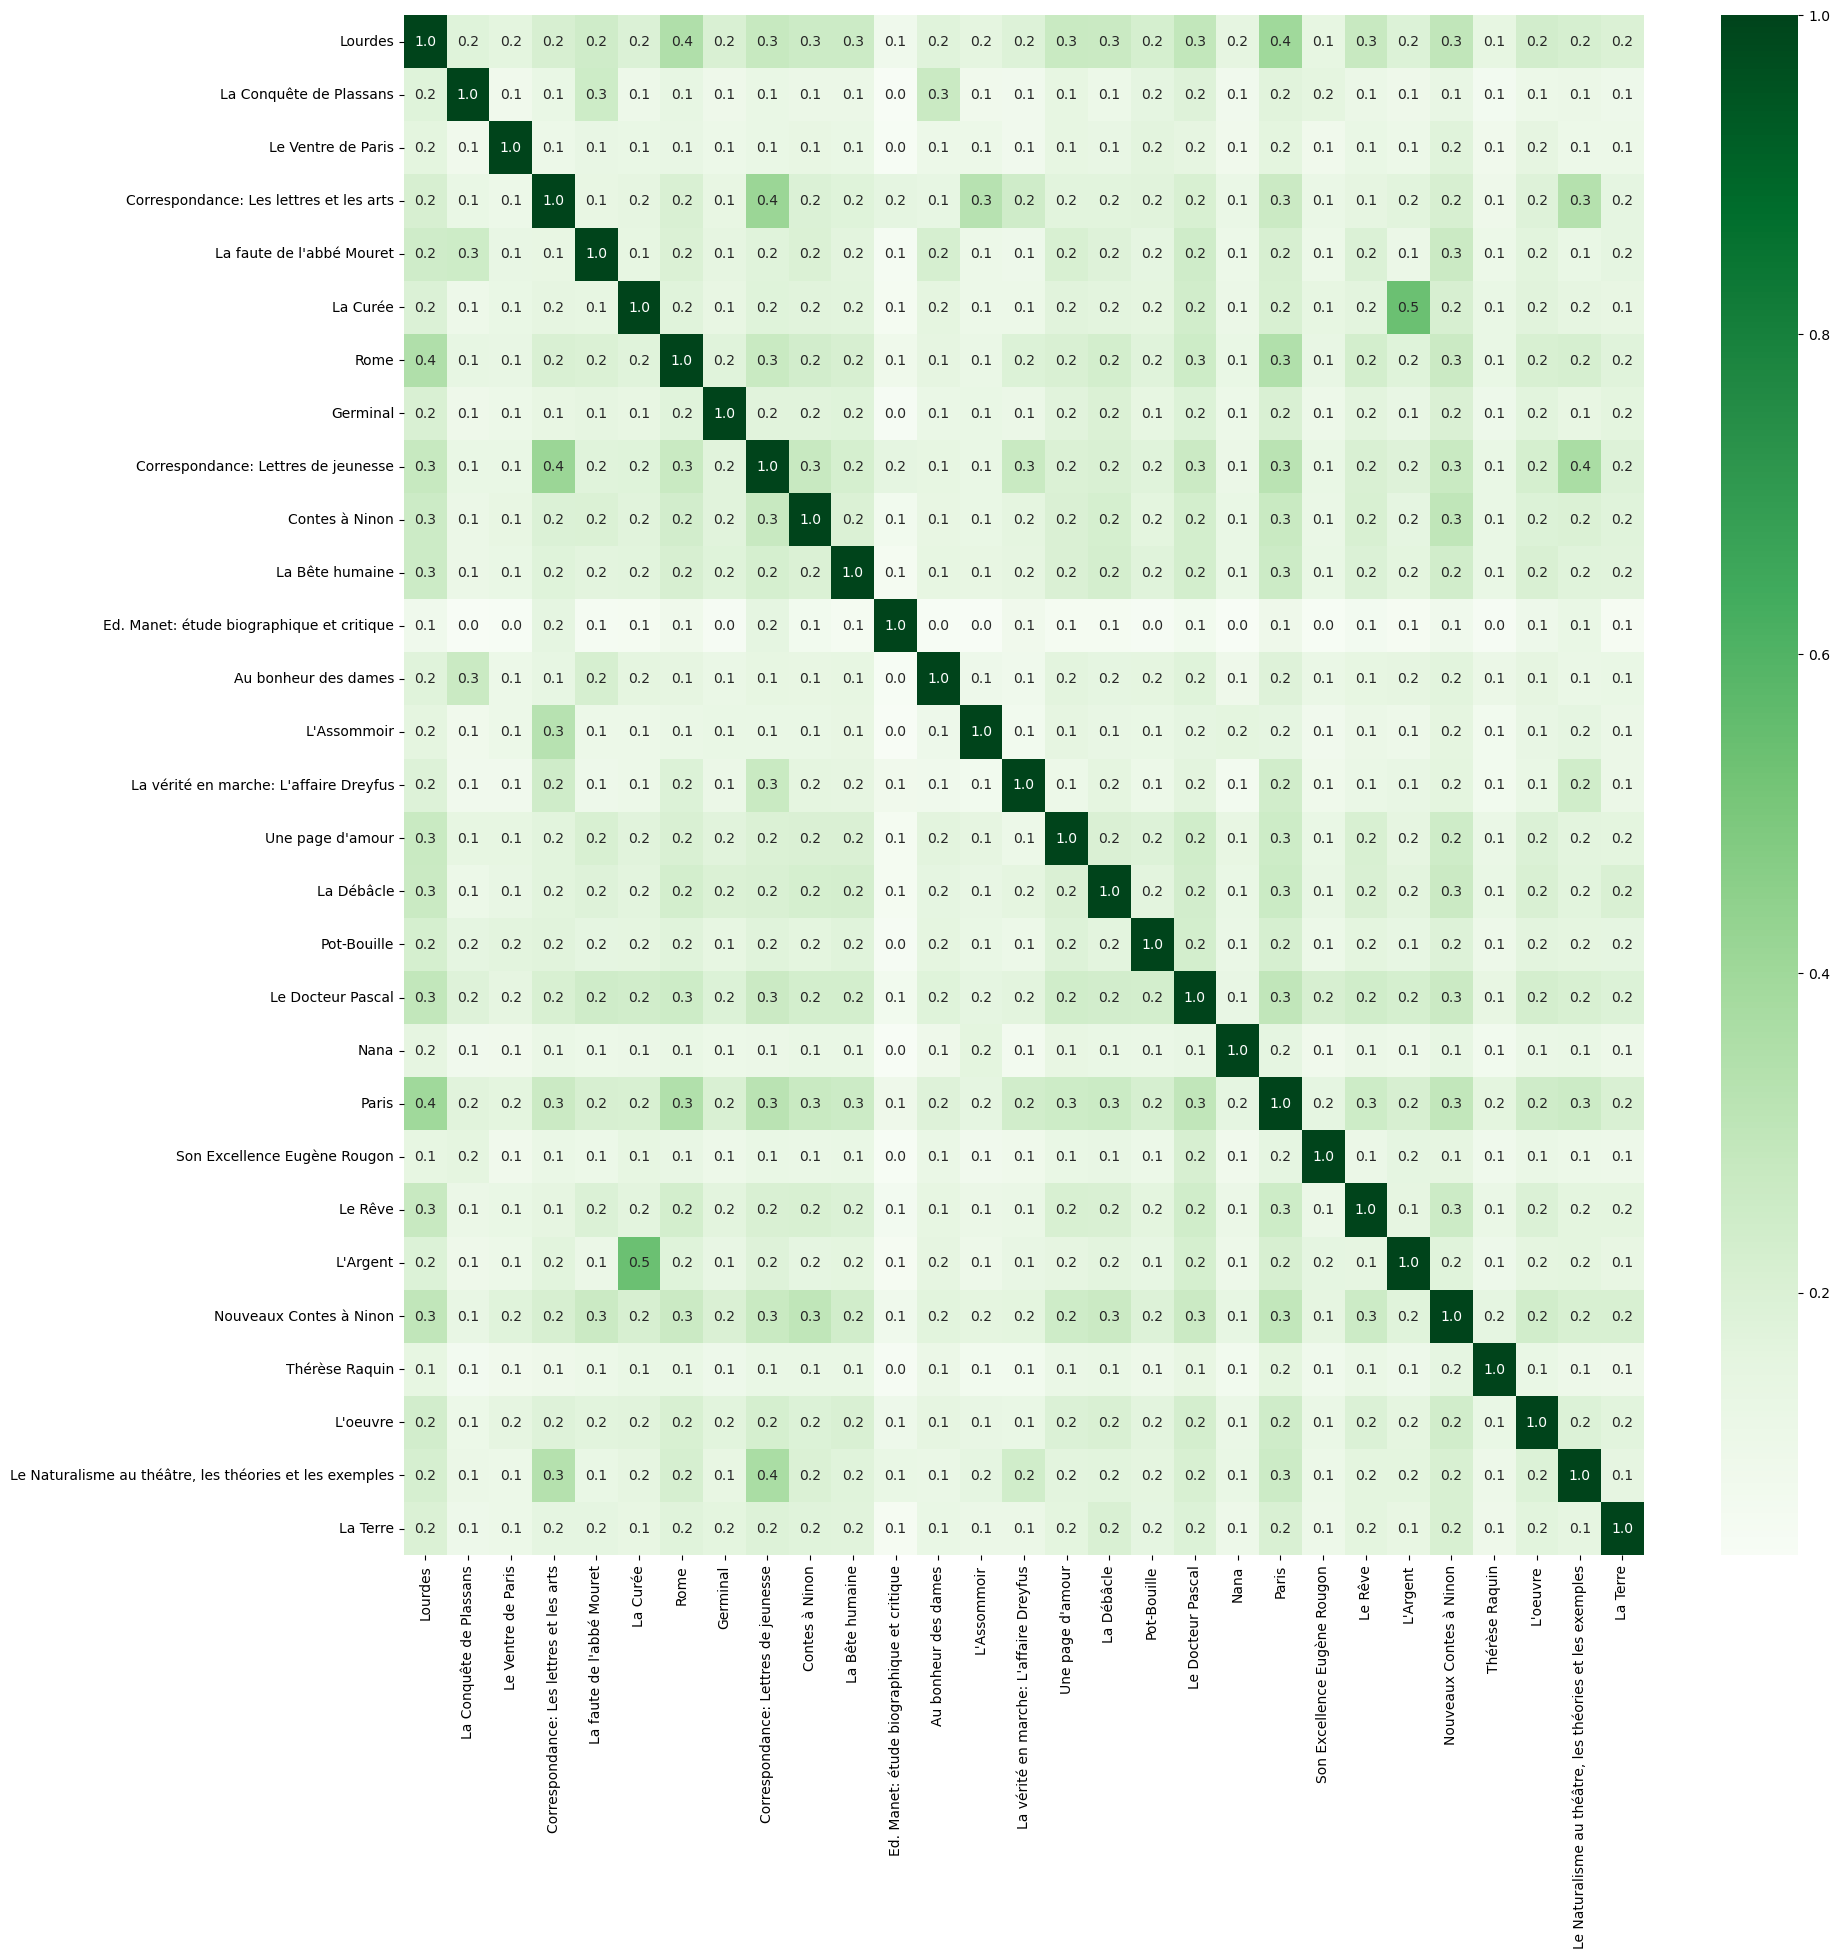

No duplicates



In [12]:
import numpy as np
import seaborn as sns
for i, (author, group) in enumerate(sel_gut_df.groupby('author')):
    print('\033[5;8;4m{}\033[0;0;0m'.format(author))
    plt.figure(figsize=(20, 20))
    if len(group)>50: #we show as much information as possible but if there are a lot of books, we can not show everything
        annot=False
        fmt_annot=''
    elif len(group)>25:
        annot=True
        fmt_annot='.1f'
    else:
        annot=True
        fmt_annot='.2f'
    sns.heatmap(sim_mtx[author], 
            xticklabels=group['title'].values, 
            yticklabels=group['title'].values, 
            annot=annot,
            fmt=fmt_annot,
            cmap='Greens')

    plt.show()
    row, col=np.where(sim_mtx[author] > 0.75)
    if row.shape[0]>len(group):
        print('Possible duplicates:\n')
    else:
        print('No duplicates\n')
    for index in zip(row, col):
        if index[0]>index[1]:
            print('{} ({}) and\n{} ({})\n\n'.format(group.iloc[index[0]]['title'],group.iloc[index[0]].name, group.iloc[index[1]]['title'],group.iloc[index[1]].name))

        

High cosine similarity between two books can mean that <ul>
    <li>they are duplicates: they are the same book or one contains the other or there is a huge overlap of text between them</li>
    <li>they share a lot of relevant (high tf idf) words (such as names, placenames, names of important concepts or objects) as they are volumes of the same novel or books of the same saga</li>
</ul>

We got good candidates for duplicates and we will again look at cosine similarity in the next notebook when we will try to group the books.

We will now use do a brute-force approach: we will consider paragraphs that are longer than 20 characters and compare every paragraph with every paragraph. This will take quite some time, around 12 minutes on my iMac 2019.  

In [13]:
import time
start_time = time.time()
dupl=pd.DataFrame(columns=['par', 'author', 'number1', 'title1' , 'number2', 'title2'])
for a in sel_gut_df['author'].unique():
    start_time = time.time()
    book_nos=sel_gut_df[sel_gut_df['author'] == a].index
    pars={}
    for i, b1 in enumerate(book_nos):
        pars[b1]=strip_book(b1)
        for b2 in book_nos[:i]:  #we only need to compare every pair of texts once
            for b1_par in pars[b1]:
                if len(b1_par)>20:
                    for b2_par in pars[b2]:
                        if b1_par==b2_par:
                            dupl.loc[len(dupl)]=[b1_par, a, b1, sel_gut_df.loc[b1, 'title'],
                                                 b2, sel_gut_df.loc[b2, 'title']]
                        
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time for {}:{}".format(a, execution_time))
display(dupl)

Execution time for George Sand:86.85522103309631
Execution time for Jules Verne:104.48674511909485
Execution time for Émile Zola:38.82889485359192
Execution time for Alphonse de Lamartine:13.98265027999878
Execution time for Anatole France:6.02602481842041
Execution time for Victor Hugo:32.60225200653076
Execution time for Guy de Maupassant:46.882807970047
Execution time for Alexandre Dumas:448.5874967575073
Execution time for Marcel Proust:1.432689905166626
Execution time for Gustave Flaubert:15.915937662124634


par            author  \
0      Charité envers les autres; Dignité envers soi-...       George Sand   
1      Charité envers les autres; Dignité envers soi-...       George Sand   
2      Charité envers les autres; Dignité envers soi-...       George Sand   
3                                  CHAPITRE QUATORZIEME.       George Sand   
4                                  CHAPITRE QUATORZIEME.       George Sand   
...                                                  ...               ...   
22630  Les remparts étaient couverts de monde quand V...  Gustave Flaubert   
22631  Ils plantèrent contre la porte leurs douze fai...  Gustave Flaubert   
22632  Il répondit que le grand Hérode suffisait à la...  Gustave Flaubert   
22633  Entre les colonnes à chapiteaux d'airain, on a...  Gustave Flaubert   
22634                              --Vous le connaissez?  Gustave Flaubert   

       number1                                             title1  number2  \
0        39101           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    41322   
1        39101           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    41322   
2        39101           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    41322   
3        39101           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    41322   
4        39101           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    41322   
...        ...                                                ...      ...   
22630    12065                                       Trois contes    57525   
22631    12065                                       Trois contes    57525   
22632    12065                                       Trois contes    57525   
22633    12065                                       Trois contes    57525   
22634    52893  OEuvres complètes de Gustave Flaubert, tome 4:...    49773   

                                                  title2  
0               Histoire de ma Vie, Livre 2 (Vol. 5 - 9)  
1               Histoire de ma Vie, Livre 2 (Vol. 5 - 9)  
2               Histoire de ma Vie, Livre 2 (Vol. 5 - 9)  
3               Histoire de ma Vie, Livre 2 (Vol. 5 - 9)  
4               Histoire de ma Vie, Livre 2 (Vol. 5 - 9)  
...                                                  ...  
22630  OEuvres complètes de Gustave Flaubert, tome 6:...  
22631  OEuvres complètes de Gustave Flaubert, tome 6:...  
22632  OEuvres complètes de Gustave Flaubert, tome 6:...  
22633  OEuvres complètes de Gustave Flaubert, tome 6:...  
22634  OEuvres complètes de Gustave Flaubert, tome 3:...  

[22635 rows x 6 columns]

Let's group the duplications by book pairs.

In [14]:
counts = dupl.groupby(['author', 'number1', 'title1', 'number2','title2']).size().reset_index(name='count')
with pd.option_context('display.max_rows', None):
    display(counts.sort_values('count', ascending=False).head(80))


author  number1  \
601            Jules Verne     5097   
600            Jules Verne     5097   
571      Guy de Maupassant    57567   
508      Guy de Maupassant    11131   
492       Gustave Flaubert    57373   
532      Guy de Maupassant    14790   
430            George Sand    39101   
529      Guy de Maupassant    11714   
505      Guy de Maupassant    10775   
603            Jules Verne     5097   
594            Jules Verne      800   
501      Guy de Maupassant    10775   
527      Guy de Maupassant    11596   
541      Guy de Maupassant    17457   
544      Guy de Maupassant    18353   
493       Gustave Flaubert    66505   
606            Jules Verne    14162   
500      Guy de Maupassant    10775   
595            Jules Verne     3456   
528      Guy de Maupassant    11597   
175        Alexandre Dumas    56054   
596            Jules Verne     3456   
511      Guy de Maupassant    11199   
188        Alexandre Dumas    58211   
534      Guy de Maupassant    14790   
613            Jules Verne    46111   
545      Guy de Maupassant    30587   
612            Jules Verne    38674   
533      Guy de Maupassant    14790   
575      Guy de Maupassant    60610   
489       Gustave Flaubert    14155   
193  Alphonse de Lamartine    22618   
530      Guy de Maupassant    14790   
599            Jules Verne     5096   
440            George Sand    39738   
441            George Sand    39738   
494      Guy de Maupassant    10746   
576      Guy de Maupassant    60610   
504      Guy de Maupassant    10775   
617            Jules Verne    54873   
502      Guy de Maupassant    10775   
389            George Sand    14372   
488       Gustave Flaubert    12065   
390            George Sand    14372   
538      Guy de Maupassant    14793   
631            Victor Hugo    22048   
537      Guy de Maupassant    14793   
499      Guy de Maupassant    10775   
546      Guy de Maupassant    30587   
636            Victor Hugo    41986   
509      Guy de Maupassant    11199   
451            George Sand    42765   
536      Guy de Maupassant    14793   
657             Émile Zola    56808   
550      Guy de Maupassant    51423   
577      Guy de Maupassant    60610   
400            George Sand    14564   
450            George Sand    42765   
422            George Sand    18075   
423            George Sand    18075   
401            George Sand    14564   
542      Guy de Maupassant    18353   
383            George Sand    13875   
230  Alphonse de Lamartine    37604   
574      Guy de Maupassant    60610   
233  Alphonse de Lamartine    37604   
496      Guy de Maupassant    10746   
382            George Sand    13875   
487       Gustave Flaubert    12065   
364            George Sand    12338   
481            George Sand    61411   
552      Guy de Maupassant    56374   
406            George Sand    14688   
469            George Sand    60812   
349         Anatole France     7268   
470            George Sand    60812   
365            George Sand    12338   
482            George Sand    61411   
407            George Sand    14688   
540      Guy de Maupassant    14793   

                                                title1  number2  \
601              20000 Lieues Sous Les Mers — Complete     5096   
600              20000 Lieues Sous Les Mers — Complete     5095   
571  Œuvres complètes de Guy de Maupassant - volume 14    14790   
508                                     Pierre et Jean    67940   
492  OEuvres complètes de Gustave Flaubert, tome 5:...    10982   
532                       Contes du jour et de la nuit    11714   
430           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    37989   
529                               Contes de la Becasse    51266   
505                                           Le Horla    67158   
603              20000 Lieues Sous Les Mers — Complete    54873   
594            Le tour du monde en quatre-vingts jours    46541   
501                                           Le Horla  

We have more than 80 pairs of texts sharing at least 50 paragraphs!
One obvious source of duplicates: we have the collected works of Maupassant and Flaubert and also some of their works individually. Let's try to keep only the complete works. They all have "complètes" in their title:

In [15]:
sel_gut_df[sel_gut_df['title'].str.contains('complètes')].sort_values("author")

title             author  \
number                                                                         
57373   OEuvres complètes de Gustave Flaubert, tome 5:...   Gustave Flaubert   
48881   OEuvres complètes de Gustave Flaubert, tome 2:...   Gustave Flaubert   
66505   OEuvres complètes de Gustave Flaubert, tome 7:...   Gustave Flaubert   
48359   OEuvres complètes de Gustave Flaubert, tome 1 ...   Gustave Flaubert   
57525   OEuvres complètes de Gustave Flaubert, tome 6:...   Gustave Flaubert   
52893   OEuvres complètes de Gustave Flaubert, tome 4:...   Gustave Flaubert   
49773   OEuvres complètes de Gustave Flaubert, tome 3:...   Gustave Flaubert   
70260        Œuvres complètes de Gustave Flaubert, tome 8   Gustave Flaubert   
67074   Œuvres complètes de Guy de Maupassant - volume 17  Guy de Maupassant   
50144   Œuvres complètes de Guy de Maupassant - volume 05  Guy de Maupassant   
57430   Œuvres complètes de Guy de Maupassant - volume 13  Guy de Maupassant   
67024   Œuvres complètes de Guy de Maupassant - volume 16  Guy de Maupassant   
52753   Œuvres complètes de Guy de Maupassant - volume 08  Guy de Maupassant   
68036   Œuvres complètes de Guy de Maupassant - volume 20  Guy de Maupassant   
57567   Œuvres complètes de Guy de Maupassant - volume 14  Guy de Maupassant   
67158   Œuvres complètes de Guy de Maupassant - volume 18  Guy de Maupassant   
46470   Œuvres complètes de Guy de Maupassant - volume 04  Guy de Maupassant   
51423   Œuvres complètes de Guy de Maupassant - volume 07  Guy de Maupassant   
53247   Œuvres complètes de Guy de Maupassant - volume 09  Guy de Maupassant   
67940   Œuvres complètes de Guy de Maupassant - volume 19  Guy de Maupassant   
46387   Œuvres complètes de Guy de Maupassant - volume 03  Guy de Maupassant   
56374   Œuvres complètes de Guy de Maupassant - volume 11  Guy de Maupassant   
68271   Œuvres complètes de Guy de Maupassant - volume 21  Guy de Maupassant   
60610   Œuvres complètes de Guy de Maupassant - volume 15  Guy de Maupassant   
55167   Œuvres complètes de Guy de Maupassant - volume 10  Guy de Maupassant   
56523   Œuvres complètes de Guy de Maupassant - volume 12  Guy de Maupassant   
45312   Œuvres complètes de Guy de Maupassant - volume 02  Guy de Maupassant   
45119   Œuvres complètes de Guy de Maupassant - volume 01  Guy de Maupassant   
51266   Œuvres complètes de Guy de Maupassant - volume 06  Guy de Maupassant   

          length    year  
number                    
57373   290438.0  1885.0  
48881   675700.0  1885.0  
66505   650034.0  1885.0  
48359   889110.0  1885.0  
57525   538104.0  1885.0  
52893   458173.0  1885.0  
49773   413164.0  1885.0  
70260   331823.0  1885.0  
67074   494956.0  1902.0  
50144   449602.0  1902.0  
57430   650131.0  1902.0  
67024   267474.0  1902.0  
52753   299799.0  1902.0  
68036   219694.0  1902.0  
57567   257537.0  1902.0  
67158   292163.0  1902.0  
46470   242742.0  1902.0  
51423   239851.0  1902.0  
53247   253705.0  1902.0  
67940   305007.0  1902.0  
46387   302813.0  1902.0  
56374   243595.0  1902.0  
68271   200051.0  1902.0  
60610   276242.0  1902.0  
55167   329121.0  1902.0  
56523   262057.0  1902.0  
45312   133946.0  1902.0  
45119   338140.0  1902.0  
51266   228080.0  1902.0

With this, both Flaubert and Maupassant seems to be quite well covered (unfortunately sometimes the volume numbers are missing even from some of the texts themselves, so it is hard to verify). Let's delete every book by Flaubert and Maupassant that is not a volume of their completed works and have a look at the remaining duplicates.
We store the cleaned up index in the no_dupl dataframe and the cleaned up duplication counts in the counts_2 dataframe.

In [16]:
no_dupl=sel_gut_df[~((sel_gut_df['author'].isin(['Guy de Maupassant', 'Gustave Flaubert'])) & (~sel_gut_df['title'].str.contains('complètes')))]
no_dupl_nos=no_dupl.index
counts2=counts[(counts["number1"].isin(no_dupl_nos))&(counts["number2"].isin(no_dupl_nos))]
with pd.option_context('display.max_rows', None):
    display(counts2.sort_values("count", ascending=False).head(50))

author  number1  \
601            Jules Verne     5097   
600            Jules Verne     5097   
430            George Sand    39101   
603            Jules Verne     5097   
594            Jules Verne      800   
606            Jules Verne    14162   
595            Jules Verne     3456   
175        Alexandre Dumas    56054   
596            Jules Verne     3456   
188        Alexandre Dumas    58211   
613            Jules Verne    46111   
612            Jules Verne    38674   
193  Alphonse de Lamartine    22618   
599            Jules Verne     5096   
440            George Sand    39738   
441            George Sand    39738   
617            Jules Verne    54873   
389            George Sand    14372   
390            George Sand    14372   
631            Victor Hugo    22048   
636            Victor Hugo    41986   
451            George Sand    42765   
657             Émile Zola    56808   
422            George Sand    18075   
400            George Sand    14564   
450            George Sand    42765   
423            George Sand    18075   
401            George Sand    14564   
383            George Sand    13875   
230  Alphonse de Lamartine    37604   
233  Alphonse de Lamartine    37604   
382            George Sand    13875   
481            George Sand    61411   
406            George Sand    14688   
364            George Sand    12338   
469            George Sand    60812   
407            George Sand    14688   
349         Anatole France     7268   
482            George Sand    61411   
365            George Sand    12338   
470            George Sand    60812   
434            George Sand    39738   
634            Victor Hugo    40239   
251  Alphonse de Lamartine    37616   
196  Alphonse de Lamartine    22618   
197  Alphonse de Lamartine    22618   
303  Alphonse de Lamartine    49397   
252  Alphonse de Lamartine    37616   
624            Victor Hugo     8454   
305  Alphonse de Lamartine    49397   

                                                title1  number2  \
601              20000 Lieues Sous Les Mers — Complete     5096   
600              20000 Lieues Sous Les Mers — Complete     5095   
430           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    37989   
603              20000 Lieues Sous Les Mers — Complete    54873   
594            Le tour du monde en quatre-vingts jours    46541   
606             Les tribulations d'un chinois en Chine    45058   
595            Le tour du monde en quatre-vingts jours      800   
175          Les trois mousquetaires, Volume  1 (of 2)    13951   
596            Le tour du monde en quatre-vingts jours    46541   
188           Les trois mousquetaires, Volume 2 (of 2)    13951   
613                                  Autour de la lune     4717   
612  De la terre à la lune, trajet direct en 97 heu...      799   
193          Cours familier de Littérature - Volume 01    37616   
599                20000 Lieues sous les mers — Part 2    54873   
440                                              Lélia    37989   
441                                              Lélia    39101   
617                   Vingt mille lieues sous les mers     5095   
389                                 Autour de la table    37989   
390                                 Autour de la table    39101   
631                                  Napoléon Le Petit     8454   
636                                    Le Rhin, Tome I     8454   
451         Histoire de ma Vie, Livre 3 (Vol. 10 - 13)    39101   
657             La vérité en marche: L'affaire Dreyfus    56622   
422                          Mademoiselle La Quintinie    37989   
400                                  Césarine Dietrich    37989   
450         Histoire de ma Vie, Livre 3 (Vol. 10 - 13)    37989   
423                          Mademoiselle La Quintinie    39101   
401                                  Césarine Dietrich    39101   
383                 Correspondance, 1812-1876 — Tome 4    13839   
230          Cours f

Now let's delete the other obvious source of duplication: books in 2 volumes versus 1 and the same books under different names.  We will delete 
<ul>
<li>The duplicates of  Vingt mille lieues sous les mers (54873):  5095, 5096, 5097 </li>
<li>The duplicate of Les tribulations d'un chinois en Chine (14162): 45058</li>
<li>The duplicates of Le Tour du Monde en 80 Jours (800): 3456, 46541</li>
<li>The duplicates of Les trois mousquetaires (13951): 56054, 58211 </li>
<li>The duplicate of Autour de la Lune (4717): 46111</li>
<li>The duplicate of De La Terre a La Lune (799): 38674</li>
</ul>


In [17]:
no_dupl = no_dupl.drop([5095, 5096, 5097, 45058, 3456, 46541, 56054, 58211, 46111, 38674])
no_dupl_nos=no_dupl.index
counts2 = counts2[(counts2["number1"].isin(no_dupl_nos))&(counts2["number2"].isin(no_dupl_nos))]
with pd.option_context('display.max_rows', None):
    display(counts2.sort_values('count', ascending=False).head(30))

author  number1  \
430            George Sand    39101   
193  Alphonse de Lamartine    22618   
440            George Sand    39738   
441            George Sand    39738   
389            George Sand    14372   
390            George Sand    14372   
631            Victor Hugo    22048   
636            Victor Hugo    41986   
451            George Sand    42765   
657             Émile Zola    56808   
422            George Sand    18075   
400            George Sand    14564   
450            George Sand    42765   
401            George Sand    14564   
423            George Sand    18075   
383            George Sand    13875   
230  Alphonse de Lamartine    37604   
233  Alphonse de Lamartine    37604   
382            George Sand    13875   
406            George Sand    14688   
364            George Sand    12338   
469            George Sand    60812   
481            George Sand    61411   
482            George Sand    61411   
470            George Sand    60812   
349         Anatole France     7268   
407            George Sand    14688   
365            George Sand    12338   
434            George Sand    39738   
196  Alphonse de Lamartine    22618   

                                                title1  number2  \
430           Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    37989   
193          Cours familier de Littérature - Volume 01    37616   
440                                              Lélia    37989   
441                                              Lélia    39101   
389                                 Autour de la table    37989   
390                                 Autour de la table    39101   
631                                  Napoléon Le Petit     8454   
636                                    Le Rhin, Tome I     8454   
451         Histoire de ma Vie, Livre 3 (Vol. 10 - 13)    39101   
657             La vérité en marche: L'affaire Dreyfus    56622   
422                          Mademoiselle La Quintinie    37989   
400                                  Césarine Dietrich    37989   
450         Histoire de ma Vie, Livre 3 (Vol. 10 - 13)    37989   
401                                  Césarine Dietrich    39101   
423                          Mademoiselle La Quintinie    39101   
383                 Correspondance, 1812-1876 — Tome 4    13839   
230          Cours familier de Littérature - Volume 10    22618   
233          Cours familier de Littérature - Volume 10    37616   
382                 Correspondance, 1812-1876 — Tome 4    13838   
406                                Un hiver à Majorque    37989   
364                            Contes d'une grand-mère    37989   
469                                            Adriani    37989   
481                                   Le beau Laurence    37989   
482                                   Le beau Laurence    39101   
470                                            Adriani    39101   
349  Monsieur Bergeret à Paris: Histoire Contemporaine    19248   
407                                Un hiver à Majorque    39101   
365                            Contes d'une grand-mère    39101   
434                                              Lélia    14372   
196          Cours familier de Littérature - Volume 01    41054   

                                        title2  count  
430                      Lettres d'un voyageur    650  
193  Cours familier de Littérature - Volume 16    225  
440                      Lettres d'un voyageur    208  
441   Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    200  
389                      Lettres d'un voyageur    156  
390   Histoire de ma Vie, Livre 1 (Vol. 1 - 4)    150  
631                 Actes et Paroles, Volume 3    135  
636                 Actes et Paroles, Volume 3     90  
451   Histoire de ma Vie, Livre 1 (Vol. 1 - 4)     87  
657    Correspondance: Les lettres et les arts     82  
422                      Lettres d'un voyageur     78  
400                      Lettres d'un voyageur     78  
450 

What are the paragraphs in "Histoire de ma Vie, Livre 1 (Vol.1 to 4)" that are duplicates?

In [18]:
dupl.loc[dupl["number1"]==39101, "par"]

0      Charité envers les autres; Dignité envers soi-...
1      Charité envers les autres; Dignité envers soi-...
2      Charité envers les autres; Dignité envers soi-...
3                                  CHAPITRE QUATORZIEME.
4                                  CHAPITRE QUATORZIEME.
                             ...                        
657                    *       *       *       *       *
658                    *       *       *       *       *
659                    *       *       *       *       *
660                    *       *       *       *       *
661                    *       *       *       *       *
Name: par, Length: 662, dtype: object

These are mostly not real sentences, just markers to seperate paragraphs! We should try to eliminate such paragraphs at a later stage. Let's have a look at the duplicate paragraphs that contain at least one alphanumeric character. 

In [19]:

dupl2=dupl[dupl['par'].str.contains(r'[a-zA-Z]')]
counts3 = dupl2.groupby(['author', 'number1', 'title1', 'number2','title2']).size().reset_index(name='count')
counts3 = counts3[(counts3["number1"].isin(no_dupl_nos))&(counts3["number2"].isin(no_dupl_nos))]
with pd.option_context('display.max_rows', None):
    display(counts3.sort_values('count', ascending=False).head(10))


author  number1  \
240      George Sand    13875   
239      George Sand    13875   
228   Anatole France     7268   
238      George Sand    13875   
235      George Sand    13837   
369    Marcel Proust     2650   
232      George Sand    13629   
51   Alexandre Dumas    13947   
251      George Sand    42765   
237      George Sand    13839   

                                                title1  number2  \
240                 Correspondance, 1812-1876 — Tome 4    13839   
239                 Correspondance, 1812-1876 — Tome 4    13838   
228  Monsieur Bergeret à Paris: Histoire Contemporaine    19248   
238                 Correspondance, 1812-1876 — Tome 4    13837   
235                 Correspondance, 1812-1876 — Tome 2    13838   
369                              Du côté de chez Swann    62100   
232                 Correspondance, 1812-1876 — Tome 1    13837   
51                   Le vicomte de Bragelonne, Tome I.    13950   
251         Histoire de ma Vie, Livre 3 (Vol. 10 - 13)    41322   
237                 Correspondance, 1812-1876 — Tome 5    13838   

                                       title2  count  
240        Correspondance, 1812-1876 — Tome 5     64  
239        Correspondance, 1812-1876 — Tome 3     55  
228                         Opinions sociales     50  
238        Correspondance, 1812-1876 — Tome 2     44  
235        Correspondance, 1812-1876 — Tome 3     38  
369                         Un amour de Swann     31  
232        Correspondance, 1812-1876 — Tome 2     21  
51         Le vicomte de Bragelonne, Tome IV.     19  
251  Histoire de ma Vie, Livre 2 (Vol. 5 - 9)     15  
237        Correspondance, 1812-1876 — Tome 3     14

Un amour de Swann is just a chapter in Du Côté de Chez Swann, we can drop it (62100).

In [20]:
no_dupl=no_dupl.drop(62100)

As for Opinions sociales and Monsieur Bergeret à Paris, they do not contain each other but have a lot of equal content. Instead of eliminating any of the two, we will make sure that we group them together, so the two works stay together and samples from them are either all in the training set or all in the test set.
As for the correspondance of George Sand:

In [21]:
dupl2[dupl2["number1"]==13839]

par       author  number1  \
853                         Je vous embrasse de coeur.  George Sand    13839   
854                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
855                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
856                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
857                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
858                  A M. ERNEST PÉRIGOIS, A LA CHÂTRE  George Sand    13839   
859                 A M. ALEXANDRE DUMAS FILS, A PARIS  George Sand    13839   
860                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
861                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
862                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
863                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
864                           A vous de toute mon âme.  George Sand    13839   
865                           A vous de toute mon âme.  George Sand    13839   
866  A SON ALTESSE LE PRINCE NAPOLÉON (JÉRÔME), A P...  George Sand    13839   
867                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
868                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
869                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
870                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
871                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
872                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
873                       A M. CHARLES PONCY, A TOULON  George Sand    13839   
874                       A M. CHARLES PONCY, A TOULON  George Sand    13839   

                                 title1  number2  \
853  Correspondance, 1812-1876 — Tome 5    13838   
854  Correspondance, 1812-1876 — Tome 5    13838   
855  Correspondance, 1812-1876 — Tome 5    13838   
856  Correspondance, 1812-1876 — Tome 5    13838   
857  Correspondance, 1812-1876 — Tome 5    13838   
858  Correspondance, 1812-1876 — Tome 5    13838   
859  Correspondance, 1812-1876 — Tome 5    13838   
860  Correspondance, 1812-1876 — Tome 5    13838   
861  Correspondance, 1812-1876 — Tome 5    13838   
862  Correspondance, 1812-1876 — Tome 5    13838   
863  Correspondance, 1812-1876 — Tome 5    13838   
864  Correspondance, 1812-1876 — Tome 5    13838   
865  Correspondance, 1812-1876 — Tome 5    13838   
866  Correspondance, 1812-1876 — Tome 5    13838   
867  Correspondance, 1812-1876 — Tome 5    13837   
868  Correspondance, 1812-1876 — Tome 5    13837   
869  Correspondance, 1812-1876 — Tome 5    13837   
870  Correspondance, 1812-1876 — Tome 5    13837   
871  Correspondance, 1812-1876 — Tome 5    13837   
872  Correspondance, 1812-1876 — Tome 5    13837   
873  Correspondance, 1812-1876 — Tome 5    13837   
874  Correspondance, 1812-1876 — Tome 5    13837   

                                 title2  
853  Correspondance, 1812-1876 — Tome 3  
854  Correspondance, 1812-1876 — Tome 3  
855  Correspondance, 1812-1876 — Tome 3  
856  Correspondance, 1812-1876 — Tome 3  
857  Correspondance, 1812-1876 — Tome 3  
858  Correspondance, 1812-1876 — Tome 3  
859  Correspondance, 1812-1876 — Tome 3  
860  Correspondance, 1812-1876 — Tome 3  
861  Correspondance, 1812-1876 — Tome 3  
862  Correspondance, 1812-1876 — Tome 3  
863  Correspondance, 1812-1876 — Tome 3  
864  Correspondance, 1812-1876 — Tome 3  
865  Correspondance, 1812-1876 — Tome 3  
866  Correspondance, 1812-1876 — Tome 3  
867  Correspondance, 1812-1876 — Tome 2  
868  Correspondance, 1812-1876 — Tome 2  
869  Correspondance, 1812-1876 — Tome 2  
870  Correspondance, 1812-1876 — Tome 2  
871  Correspondance, 1812-1876 — Tome 2  
872  Correspondance, 1812-1876 — Tome 2  
873  Correspondance, 1812-1876 — Tome 2  
874  Correspondance, 1812-1876 — Tome 2

These seem to be mostly the addressees of the letters. As both these sentences and other mentions would make it too easy for the classifier to recognize a text from the names mentioned and not the style, we will keep all correspondence together, so that samples from them are either all in the training set or all in the test set.

As for Lamartine:

In [22]:
dupl2.loc[dupl2["author"]=="Alphonse de Lamartine", "par"].value_counts().head()

(_La suite au prochain entretien._)                                           47
(_La suite au mois prochain._)                                                25
Paris.--Typ. de Rouge frères, Dunon et Fresné, rue du Four-St-Germain, 43.    14
(_La suite au prochain Entretien._)                                            6
Typ. de Rouge frères, Dunon et Fresné, rue du Four-St-Germain, 43              5
Name: par, dtype: int64

Most of these texts occur between units of the texts called "entretiens":

In [23]:

vol28=finalstrip(49397)
index=vol28.index('Rouge frères')
print(vol28[index-300:index+300])

t de ressembler à tout le monde, son mérite à lui c'est de ne ressembler à personne. Un peuple littéraire qui commence par le naturel et qui sait se rendre intéressant est bien sûr d'arriver au sublime; il ne lui faut que du temps.
LAMARTINE.
20 février 1864.
FIN DE L'ENTRETIEN CXXXII.
Paris.--Typ. Rouge frères, Dunon et Fresné, rue du Four Saint-Germain, 43.

 CXXXIVe ENTRETIEN

 RÉMINISCENCE LITTÉRAIRE
OEUVRES DE CLOTILDE DE SURVILLE
 I
Il y a une inspiration ineffaçable dans certains lieux, dans certains climats, dans certaines impressions de jeunesse et dans certaines mémoires qui nous rep


As this would be too easy to recognise (see also the reflections in 04 Creation of train and test sets), we will not include in the test/training set chunks that contain "LAMARTINE" (the signature after each entretien), "ENTRETIEN" or "Rouge frères, Dunon et Fresné" and will thus avoid most occurrences.

## Second look at book length distributions

Now that we eliminated the duplicates, we can have a look at book length distributions per author.

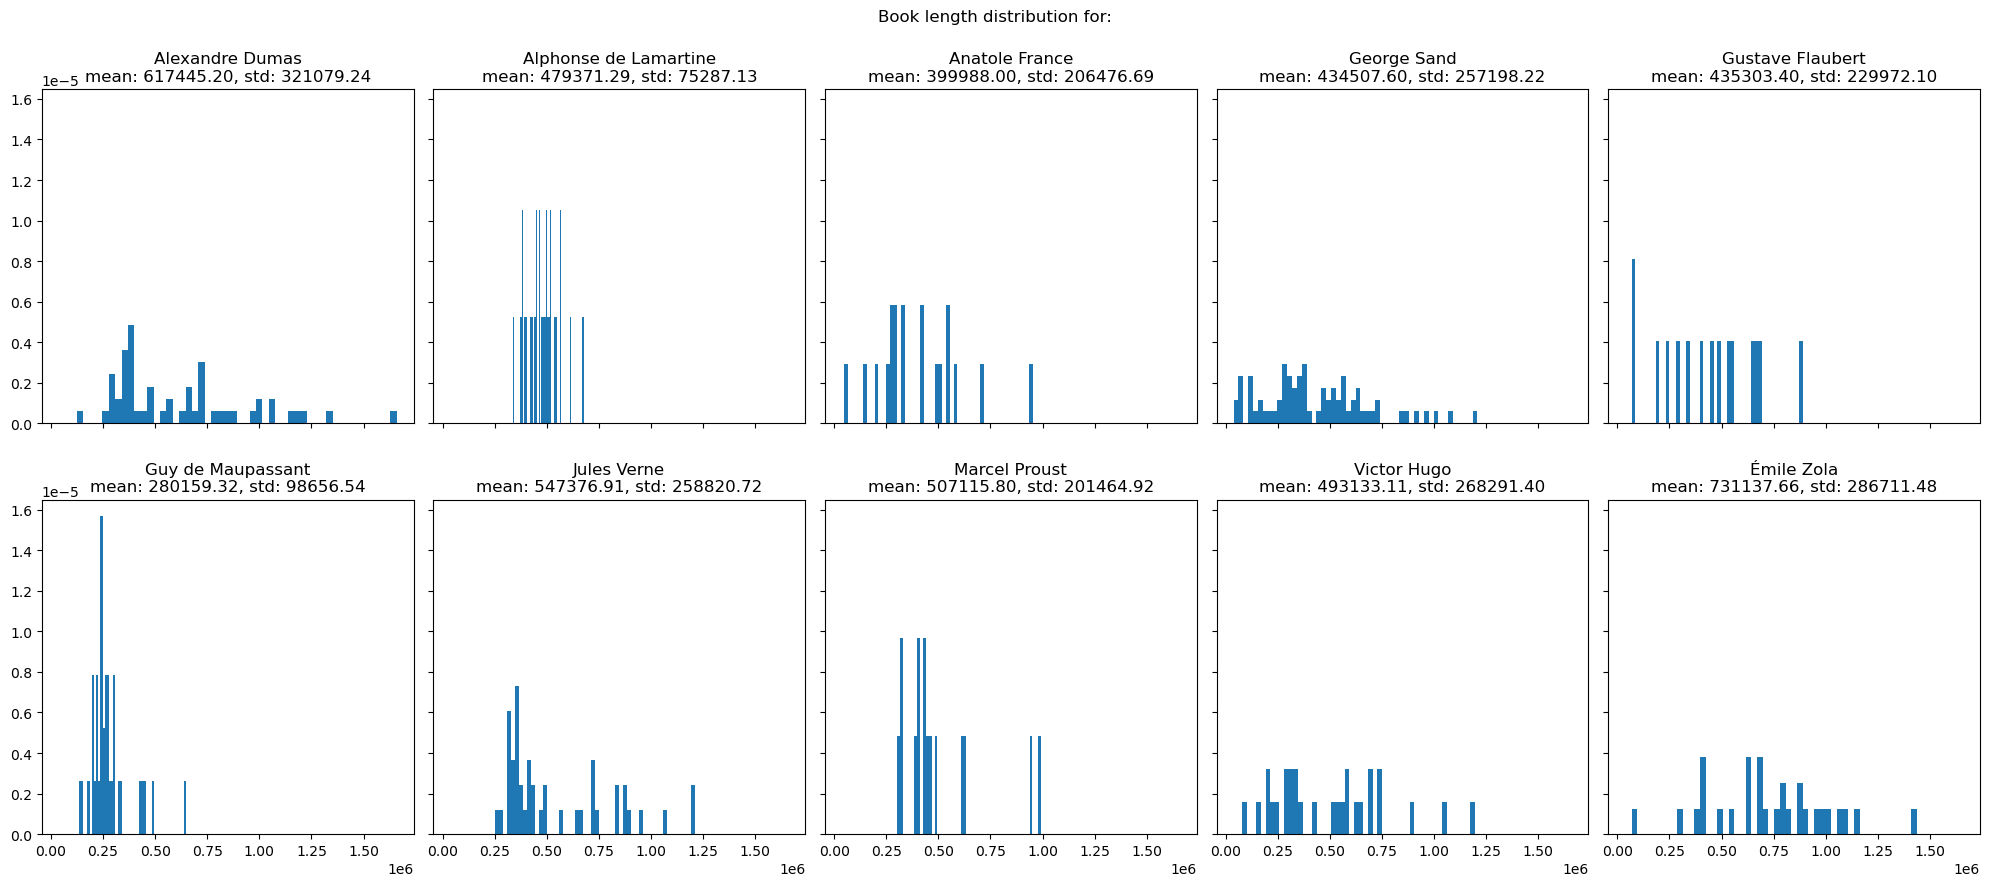

In [24]:
import numpy as np
fig, axs = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20, 9))
graph_number=0

for author, group in sel_gut_df.groupby('author'):

    ax=axs.flat[graph_number]
    ax.hist(group['length'], density=True, bins=50)
    ax.set_title("{}\nmean: {:.2f}, std: {:.2f}".format(author, np.mean(group['length']), np.std(group['length'])))
    graph_number+=1
    #ax.set_ylim(0, 1e-6)
fig.suptitle('Book length distribution for:');
plt.tight_layout()
plt.show()

As we mentioned in the beginning, it is still not easy to draw conclusions from the length data as the genres are different and what is considered a book in Gutenberg is somewhat arbitrary.
We can see that Lamartine's work was divided in more equal volumes than Maupassant and Flaubert. Proust and Verne have no short (<250000 word) works in our (quite extensive) sample.

## Saving of data

We save our book index and create folders for the books in their stripped form (with the beginning and the end cut off) without the book duplications. As explained above, other text-level duplications will be dealt with by grouping certain books together, and every group book will be used either for the training set or the test set but not both.

In [25]:
no_dupl.to_csv('no_dupl.csv')
import os
if not os.path.exists("stripped_filtered"):
    os.mkdir("stripped_filtered")
for a in no_dupl["author"]:
    if not os.path.exists(os.path.join("stripped_filtered", a)):
        os.mkdir(os.path.join("stripped_filtered", a))

In [26]:
for i, row in no_dupl.iterrows():
    filename=os.path.join("stripped_filtered", row["author"], str(i))
    if not os.path.isfile(filename):
        with open(filename, 'w') as f:
            f.write(finalstrip(i))

Now we are ready to do some deeper data exploration and to create chunks from our texts.